# MACHINE LEARNING - ASSIGNMENT 2

## Adult Income Prediction using Multiple Machine Learning Models

STUDENT INFORMATION (REQUIRED - DO NOT DELETE)

BITS ID: 2025aa05564

Name: Prajwal Rastogi

Email: 2025aa0564@wilp.ac.in

Date: February 14, 2026

## Part 1: Setup and Data Loading

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_auc_score,
                             matthews_corrcoef)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# XGBoost import with error handling
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("="*70)
    print("WARNING: XGBoost is not installed. Model 6 (XGBoost) will be skipped.")
    print("To install XGBoost, run: pip install xgboost")
    print("Or: conda install -c conda-forge xgboost")
    print("="*70)

import warnings
warnings.filterwarnings('ignore')

# Set plotting style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")
print("\nRequired Models:")
print("1. Logistic Regression")
print("2. Decision Tree Classifier")
print("3. K-Nearest Neighbor Classifier")
print("4. Naive Bayes Classifier (Gaussian)")
print("5. Random Forest (Ensemble)")
print("6. XGBoost (Ensemble)")

Libraries imported successfully!

Required Models:
1. Logistic Regression
2. Decision Tree Classifier
3. K-Nearest Neighbor Classifier
4. Naive Bayes Classifier (Gaussian)
5. Random Forest (Ensemble)
6. XGBoost (Ensemble)


### 1.1 Load Dataset

In [21]:
# Load Adult Income (Census Income) Dataset from UCI
# Dataset URL: https://archive.ics.uci.edu/ml/datasets/adult
# This dataset has 14 features and 48K+ instances - perfect for this assignment!

try:
    # Method 1: Load from UCI repository
    url_train = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
    url_test = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
    
    # Column names for the dataset
    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
                    'marital-status', 'occupation', 'relationship', 'race', 'sex',
                    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
    
    # Load training data
    df_train = pd.read_csv(url_train, names=column_names, sep=', ', engine='python', na_values='?')
    
    # Load test data (skip first row which is a header)
    df_test = pd.read_csv(url_test, names=column_names, sep=', ', engine='python', 
                          skiprows=1, na_values='?')
    
    # Combine train and test for full dataset
    df = pd.concat([df_train, df_test], ignore_index=True)
    
    # Clean income column (remove trailing dots)
    df['income'] = df['income'].str.replace('.', '', regex=False)
    
    print("Dataset loaded from UCI repository!")
    print(f"Training samples: {len(df_train)}")
    print(f"Test samples: {len(df_test)}")
    
except Exception as e:
    print(f"Error loading from UCI: {e}")
    print("\nTrying alternative source...")
    try:
        # Alternative: Load from Kaggle-style URL
        url = 'https://raw.githubusercontent.com/ronitf/adult-dataset/master/adult.csv'
        df = pd.read_csv(url, na_values='?')
        print("Dataset loaded from alternative source!")
    except Exception as e2:
        print(f"Error loading from alternative source: {e2}")
        print("\nUsing sklearn breast cancer dataset as fallback...")
        # Fallback: Use sklearn breast cancer dataset (30 features, 569 instances)
        from sklearn.datasets import load_breast_cancer
        data = load_breast_cancer()
        df = pd.DataFrame(data.data, columns=data.feature_names)
        df['income'] = data.target
        df['income'] = df['income'].map({0: '<=50K', 1: '>50K'})
        print("Dataset loaded from sklearn (fallback)!")

print("\n" + "="*70)
print("Dataset loaded successfully!")
print("="*70)
print(f"Shape: {df.shape}")
print(f"Features: {df.shape[1] - 1} (excluding target)")
print(f"Instances: {df.shape[0]}")
print(f"\nColumn names:")
print(df.columns.tolist())
print(f"\nFirst few rows:")
df.head()

Dataset loaded from UCI repository!
Training samples: 32561
Test samples: 16281

Dataset loaded successfully!
Shape: (48842, 15)
Features: 14 (excluding target)
Instances: 48842

Column names:
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

First few rows:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### 1.2 Exploratory Data Analysis (EDA)

In [22]:
# Basic information about the dataset
print("="*70)
print("DATASET INFORMATION")
print("="*70)
print("\nDataset Info:")
print(df.info())
print("\n" + "="*70)
print("\nDataset Description (Statistical Summary):")
print(df.describe())
print("\n" + "="*70)
print("\nMissing Values:")
missing = df.isnull().sum()
print(missing)
print(f"\nTotal missing values: {missing.sum()}")
print("\n" + "="*70)
print("\nData Types:")
print(df.dtypes)
print("\n" + "="*70)
print("\nTarget Variable Distribution (Quality):")
if 'quality' in df.columns:
    print(df['quality'].value_counts().sort_index())
    print(f"\nQuality range: {df['quality'].min()} to {df['quality'].max()}")

DATASET INFORMATION

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       46043 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      46033 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  47985 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
None


Dataset Description (Statistical Summary):
        

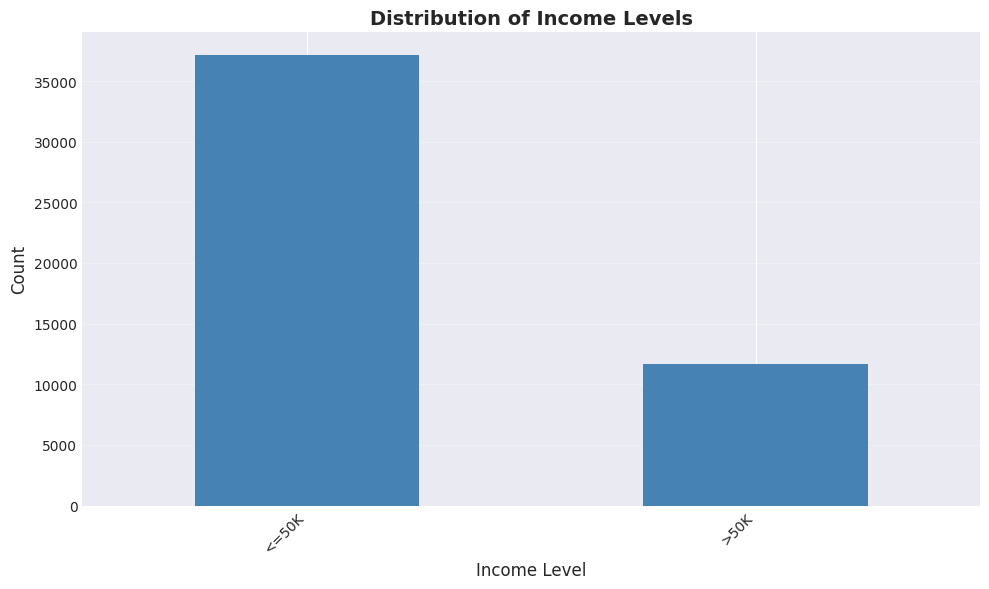

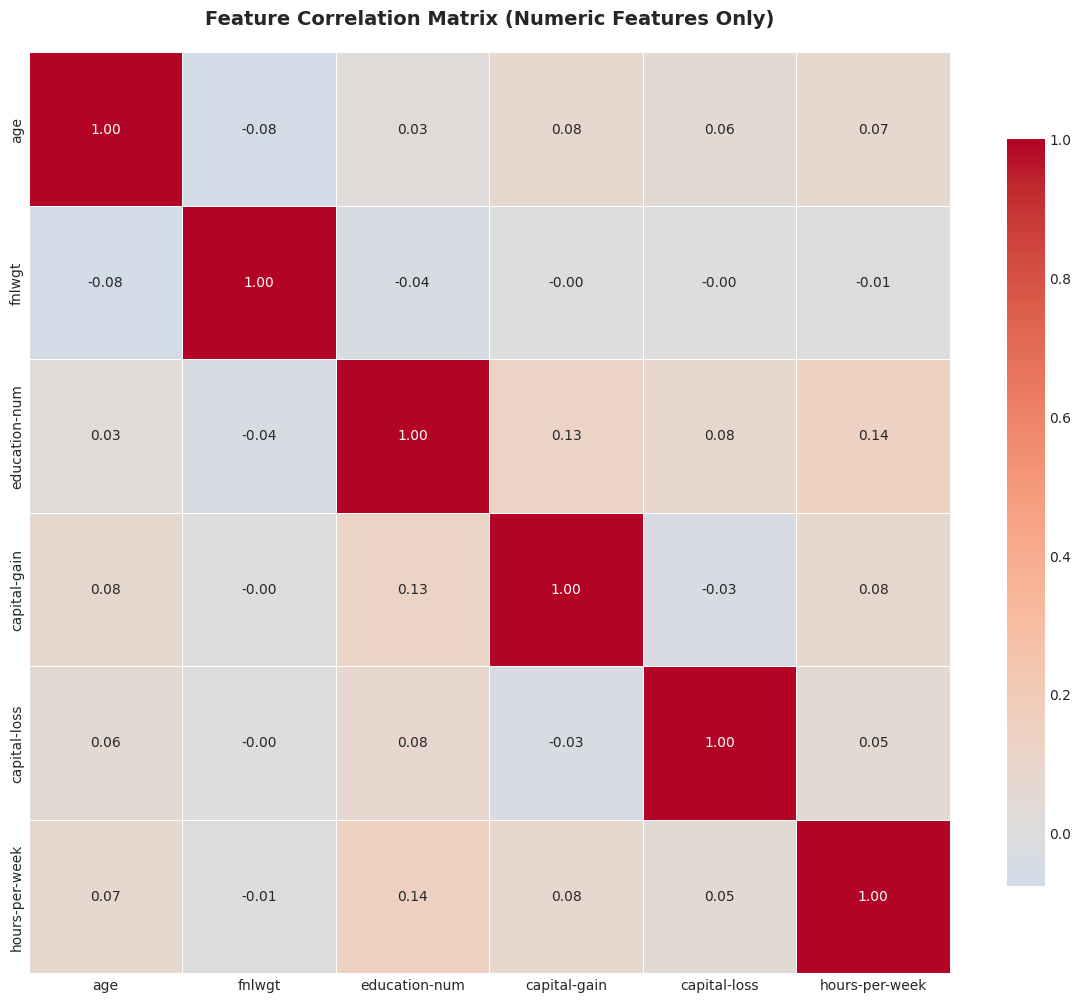

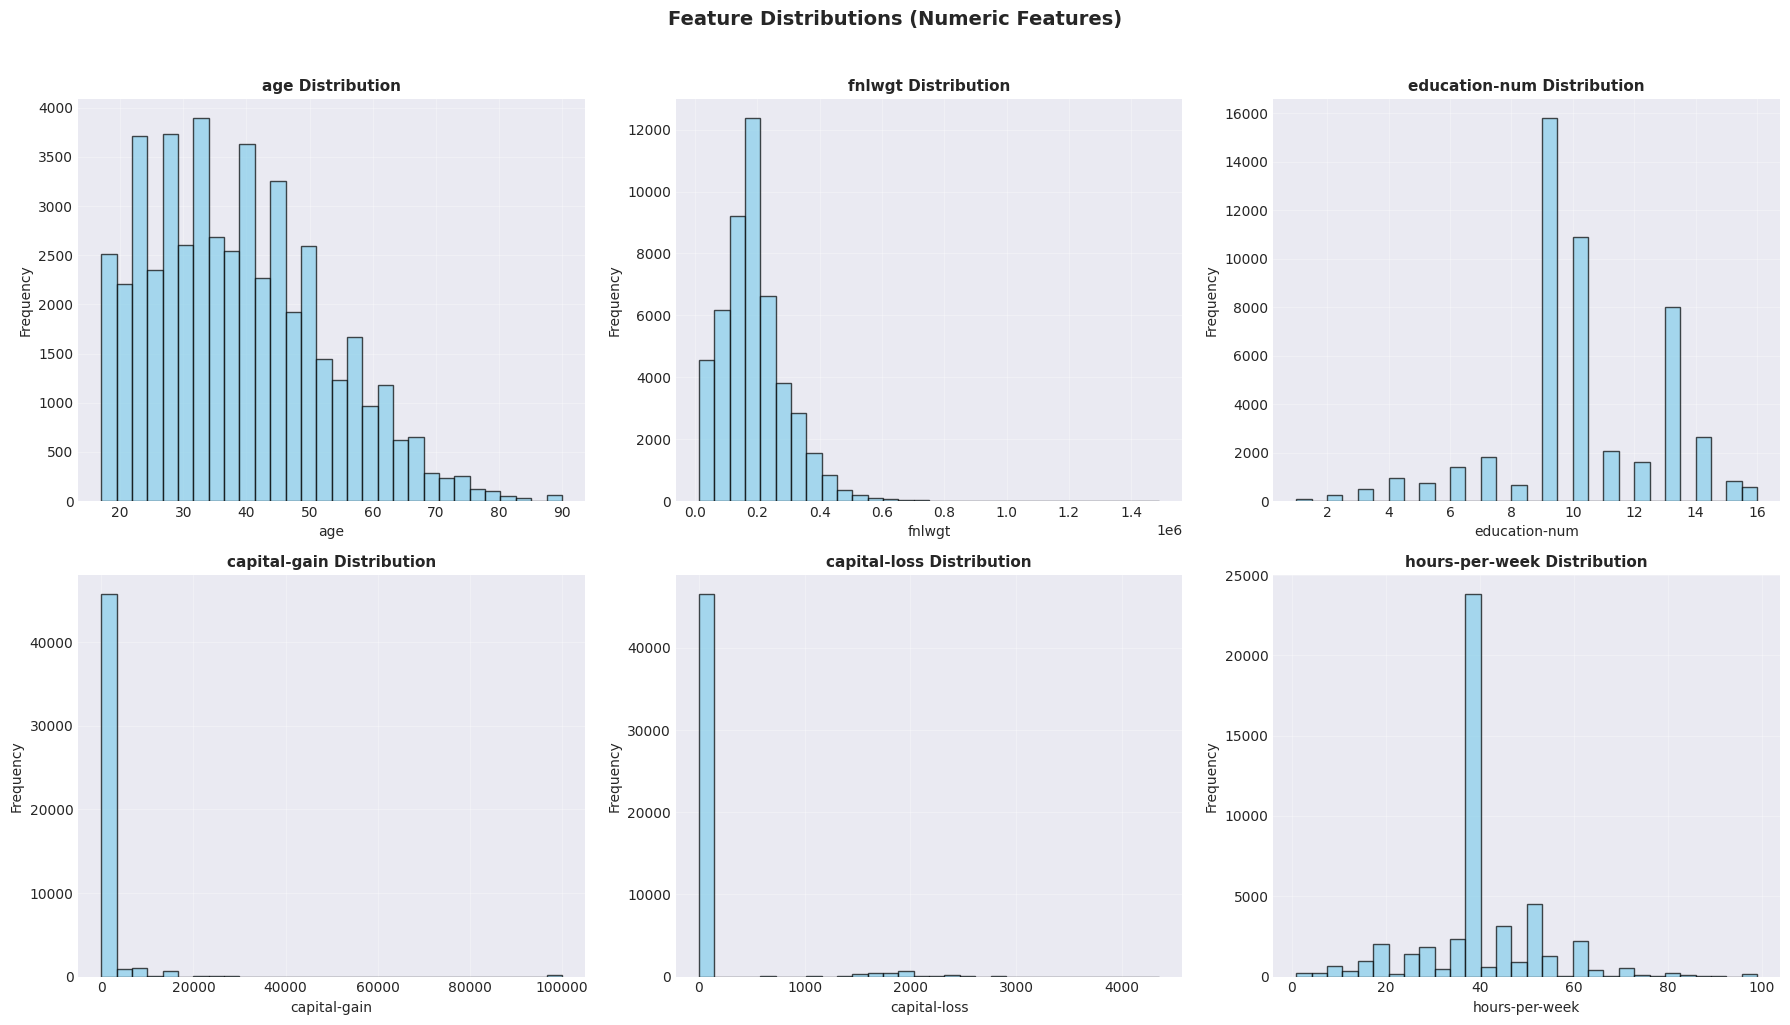

In [24]:
# Visualizations

# 1. Distribution of target variable (Income)
plt.figure(figsize=(10, 6))
if 'income' in df.columns:
    df['income'].value_counts().sort_index().plot(kind='bar', color='steelblue')
    plt.title('Distribution of Income Levels', fontsize=14, fontweight='bold')
    plt.xlabel('Income Level', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
elif 'target' in df.columns:
    df['target'].value_counts().sort_index().plot(kind='bar', color='steelblue')
    plt.title('Distribution of Target Variable', fontsize=14, fontweight='bold')
    plt.xlabel('Target Class', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# 2. Correlation matrix (only for numeric columns)
plt.figure(figsize=(12, 10))
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])
if len(numeric_df.columns) > 0:
    correlation_matrix = numeric_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                fmt='.2f', square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title('Feature Correlation Matrix (Numeric Features Only)', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
else:
    print("No numeric columns available for correlation matrix.")

# 3. Feature distributions (numeric features only)
# Select numeric features (exclude target columns)
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove target columns if they exist
for target_col in ['income', 'target', 'quality']:
    if target_col in numeric_features:
        numeric_features.remove(target_col)

if len(numeric_features) > 0:
    # Plot distributions of top 6 features
    n_features = min(6, len(numeric_features))
    n_rows = 2
    n_cols = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10))
    axes = axes.ravel()
    
    for idx, feature in enumerate(numeric_features[:n_features]):
        axes[idx].hist(df[feature], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{feature} Distribution', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(alpha=0.3)
    
    # Hide unused subplots
    for idx in range(n_features, n_rows * n_cols):
        axes[idx].axis('off')
    
    plt.suptitle('Feature Distributions (Numeric Features)', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No numeric features available for distribution plots.")

## Part 2: Data Preprocessing

In [51]:
# Data Preprocessing

print("="*70)
print("DATA PREPROCESSING")
print("="*70)

# 1. Handle missing values
print("\n1. Checking for missing values...")
missing_count = df.isnull().sum().sum()
if missing_count > 0:
    print(f"Found {missing_count} missing values. Handling them...")
    # Fill numeric columns with median
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
    
    # Fill categorical columns with mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            mode_val = df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown'
            df[col] = df[col].fillna(mode_val)
    print("Missing values handled!")
else:
    print("No missing values found!")

# 2. Prepare target variable first (before encoding features)
print("\n2. Preparing target variable...")
if 'income' in df.columns:
    y = df['income'].copy()
    df_features = df.drop('income', axis=1)
elif 'target' in df.columns:
    y = df['target'].copy()
    df_features = df.drop('target', axis=1)
else:
    # Use last column as target
    y = df.iloc[:, -1].copy()
    df_features = df.iloc[:, :-1]

# Encode target variable if it's categorical
if y.dtype == 'object':
    from sklearn.preprocessing import LabelEncoder
    le_target = LabelEncoder()
    y = le_target.fit_transform(y)
    print(f"Target encoded. Classes: {le_target.classes_}")
else:
    print("Target is already numeric.")

# 3. Handle categorical variables in features
print("\n3. Encoding categorical features...")
from sklearn.preprocessing import LabelEncoder

# Get all categorical columns from features dataframe
categorical_cols = df_features.select_dtypes(include=['object']).columns.tolist()

if len(categorical_cols) > 0:
    print(f"Found {len(categorical_cols)} categorical columns: {categorical_cols}")
    le_dict = {}
    for col in categorical_cols:
        # Fill any remaining NaN
        if df_features[col].isnull().sum() > 0:
            mode_val = df_features[col].mode()[0] if len(df_features[col].mode()) > 0 else 'Unknown'
            df_features[col] = df_features[col].fillna(mode_val)
        
        # Encode using LabelEncoder
        le = LabelEncoder()
        df_features[col] = le.fit_transform(df_features[col].astype(str))
        le_dict[col] = le
        
        # Force conversion to numeric (int64)
        df_features[col] = df_features[col].astype(np.int64)
    
    print("Categorical variables encoded and converted to numeric.")
else:
    print("No categorical variables to encode.")

# 4. Create X with only numeric columns
print("\n4. Creating feature matrix X...")
X = df_features.select_dtypes(include=[np.number])

# Final verification - ensure ALL columns are numeric
non_numeric = X.select_dtypes(exclude=[np.number]).columns.tolist()
if len(non_numeric) > 0:
    print(f"WARNING: Still found non-numeric columns: {non_numeric}")
    print("Attempting to convert...")
    for col in non_numeric:
        X[col] = pd.to_numeric(X[col], errors='coerce')
    X = X.select_dtypes(include=[np.number])
    # Fill any NaN
    X = X.fillna(X.median())

# Convert to numpy array to ensure all numeric
X = X.values if isinstance(X, pd.DataFrame) else X

# Convert back to DataFrame with proper column names
if isinstance(X, np.ndarray):
    X = pd.DataFrame(X, columns=df_features.select_dtypes(include=[np.number]).columns)

print(f"\n✓ Preprocessing Summary:")
print(f"  Features shape: {X.shape}")
print(f"  Target shape: {y.shape}")
print(f"  Number of features: {X.shape[1]}")
print(f"  Number of instances: {X.shape[0]}")
print(f"  Feature names: {list(X.columns)}")
print(f"\n  Feature data types:")
print(X.dtypes)
print(f"\n  Target distribution:")
print(pd.Series(y).value_counts().sort_index())

# Final verification
if X.select_dtypes(exclude=[np.number]).empty:
    print("\n✓ SUCCESS: All features are numeric - ready for scaling!")
else:
    print("\n✗ ERROR: Some features are still non-numeric!")
    print(f"  Non-numeric columns: {X.select_dtypes(exclude=[np.number]).columns.tolist()}")
    raise ValueError("Cannot proceed: Non-numeric columns found in features!")

print("\n" + "="*70)
print("Preprocessing completed successfully!")
print("="*70)
print("="*70)

DATA PREPROCESSING

1. Checking for missing values...
No missing values found!

2. Preparing target variable...
Target encoded. Classes: ['<=50K' '>50K']

3. Encoding categorical features...
Found 8 categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Categorical variables encoded and converted to numeric.

4. Creating feature matrix X...

✓ Preprocessing Summary:
  Features shape: (48842, 14)
  Target shape: (48842,)
  Number of features: 14
  Number of instances: 48842
  Feature names: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']

  Feature data types:
age               int64
workclass         int64
fnlwgt            int64
education         int64
education-num     int64
marital-status    int64
occupation        int64
relationship      int64
race              int64


In [26]:
# Train-Test Split and Feature Scaling

# Ensure all features are numeric before splitting
print("\n" + "="*70)
print("TRAIN-TEST SPLIT AND FEATURE SCALING")
print("="*70)

# CRITICAL: Force all columns to numeric before split
print("\nStep 1: Ensuring all features are numeric...")
if isinstance(X, pd.DataFrame):
    # Get column names before conversion
    col_names = X.columns.tolist()
    
    # Convert each column to numeric explicitly
    for col in col_names:
        # Try to convert to numeric
        X[col] = pd.to_numeric(X[col], errors='coerce')
    
    # Fill any NaN created by conversion
    X = X.fillna(X.median())
    
    # Select only numeric columns
    X = X.select_dtypes(include=[np.number])
    
    # Verify no non-numeric columns remain
    non_numeric = X.select_dtypes(exclude=[np.number]).columns.tolist()
    if len(non_numeric) > 0:
        raise ValueError(f"ERROR: Non-numeric columns still exist after conversion: {non_numeric}")
    
    print(f"✓ All {X.shape[1]} features are numeric")
    print(f"  Feature dtypes: {X.dtypes.unique()}")
else:
    # If X is not a DataFrame, convert it
    X = pd.DataFrame(X)
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')
    X = X.fillna(X.median())
    X = X.select_dtypes(include=[np.number])

# Split the data into training and testing sets
print("\nStep 2: Performing train-test split...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✓ Train-Test Split Complete:")
print(f"  Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"  Test set: {X_test.shape[0]} samples, {X_test.shape[1]} features")

# CRITICAL: Convert to numpy arrays before scaling to ensure all numeric
print("\nStep 3: Converting to numpy arrays for scaling...")
X_train_array = X_train.values if isinstance(X_train, pd.DataFrame) else np.array(X_train, dtype=np.float64)
X_test_array = X_test.values if isinstance(X_test, pd.DataFrame) else np.array(X_test, dtype=np.float64)

# Verify arrays are numeric
if not np.issubdtype(X_train_array.dtype, np.number):
    raise ValueError(f"ERROR: X_train_array is not numeric. dtype: {X_train_array.dtype}")
if not np.issubdtype(X_test_array.dtype, np.number):
    raise ValueError(f"ERROR: X_test_array is not numeric. dtype: {X_test_array.dtype}")

print(f"✓ Arrays verified as numeric (dtype: {X_train_array.dtype})")

# Feature Scaling (StandardScaler - important for Logistic Regression, KNN, and Naive Bayes)
print("\nStep 4: Applying StandardScaler...")
try:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_array)
    X_test_scaled = scaler.transform(X_test_array)
    print("✓ Feature scaling successful!")
except Exception as e:
    print(f"✗ ERROR during scaling: {e}")
    print(f"  X_train_array dtype: {X_train_array.dtype}")
    print(f"  X_train_array shape: {X_train_array.shape}")
    print(f"  Sample values: {X_train_array[:3, :3]}")
    raise

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print(f"\n✓ Feature Scaling Complete:")
print(f"  Scaled training set: {X_train_scaled.shape}")
print(f"  Scaled test set: {X_test_scaled.shape}")
print(f"  Scaled data types: {X_train_scaled.dtypes.unique()}")

print("\n" + "="*70)
print("Train-Test Split and Scaling completed successfully!")
print("="*70)


TRAIN-TEST SPLIT AND FEATURE SCALING

Step 1: Ensuring all features are numeric...
✓ All 14 features are numeric
  Feature dtypes: [dtype('int64')]

Step 2: Performing train-test split...
✓ Train-Test Split Complete:
  Training set: 39073 samples, 14 features
  Test set: 9769 samples, 14 features

Step 3: Converting to numpy arrays for scaling...
✓ Arrays verified as numeric (dtype: int64)

Step 4: Applying StandardScaler...
✓ Feature scaling successful!

✓ Feature Scaling Complete:
  Scaled training set: (39073, 14)
  Scaled test set: (9769, 14)
  Scaled data types: [dtype('float64')]

Train-Test Split and Scaling completed successfully!


## Part 3: Model Implementation

This section implements 6 classification models as per assignment requirements:
1. Logistic Regression
2. Decision Tree Classifier
3. K-Nearest Neighbor Classifier
4. Naive Bayes Classifier (Gaussian)
5. Random Forest (Ensemble)
6. XGBoost (Ensemble)

Each model will be evaluated using 6 metrics: Accuracy, AUC Score, Precision, Recall, F1 Score, and MCC Score.

### 3.1 Model 1: Logistic Regression

In [27]:
# Model 1: Logistic Regression
print("="*70)
print("MODEL 1: LOGISTIC REGRESSION")
print("="*70)

# Initialize and train the model
model1 = LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr')
print("Training Logistic Regression model...")
model1.fit(X_train_scaled, y_train)

# Make predictions
y_pred1 = model1.predict(X_test_scaled)
y_pred1_proba = model1.predict_proba(X_test_scaled)

print("Model 1 (Logistic Regression) trained successfully!")
print(f"Model parameters: max_iter=1000, multi_class='ovr'")

MODEL 1: LOGISTIC REGRESSION
Training Logistic Regression model...
Model 1 (Logistic Regression) trained successfully!
Model parameters: max_iter=1000, multi_class='ovr'


MODEL 1: LOGISTIC REGRESSION - EVALUATION METRICS

1. Accuracy:  0.8229 (82.29%)
2. AUC Score: 0.8492
3. Precision: 0.8107
4. Recall:    0.8229
5. F1 Score:  0.8088
6. MCC Score: 0.4637

----------------------------------------------------------------------
Detailed Classification Report:
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      7431
           1       0.70      0.46      0.55      2338

    accuracy                           0.82      9769
   macro avg       0.77      0.70      0.72      9769
weighted avg       0.81      0.82      0.81      9769


----------------------------------------------------------------------
Confusion Matrix:
----------------------------------------------------------------------
[[6973  458]
 [1272 1066]]


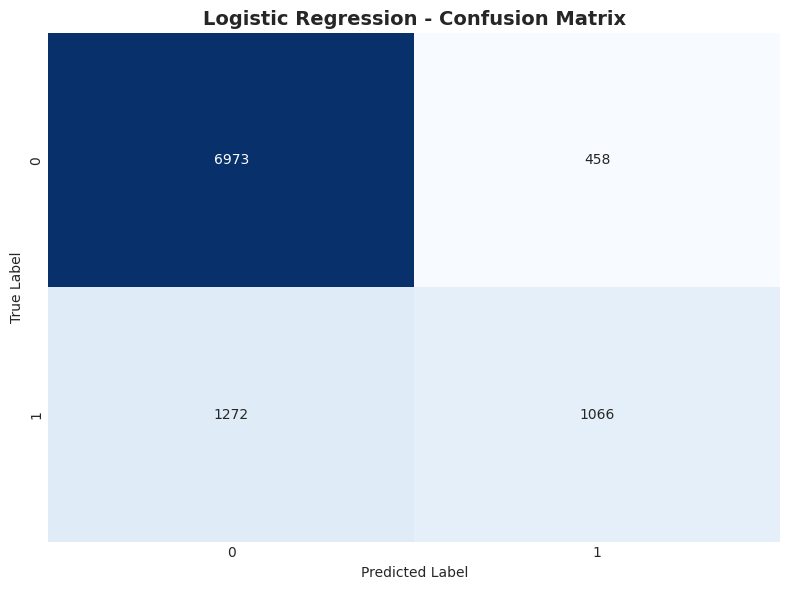

In [28]:
# Model 1 Evaluation - All 6 Required Metrics
print("="*70)
print("MODEL 1: LOGISTIC REGRESSION - EVALUATION METRICS")
print("="*70)

# Calculate all 6 required metrics
accuracy1 = accuracy_score(y_test, y_pred1)
precision1 = precision_score(y_test, y_pred1, average='weighted', zero_division=0)
recall1 = recall_score(y_test, y_pred1, average='weighted', zero_division=0)
f1_1 = f1_score(y_test, y_pred1, average='weighted', zero_division=0)
mcc1 = matthews_corrcoef(y_test, y_pred1)

# AUC Score (handles both binary and multi-class)
try:
    # Check if binary classification
    if len(np.unique(y_test)) == 2:
        # Binary classification - use probabilities for positive class
        auc1 = roc_auc_score(y_test, y_pred1_proba[:, 1])
    else:
        # Multi-class classification - use one-vs-rest
        auc1 = roc_auc_score(y_test, y_pred1_proba, multi_class='ovr', average='weighted')
except:
    try:
        # Fallback for multi-class
        auc1 = roc_auc_score(y_test, y_pred1_proba, multi_class='ovr', average='macro')
    except:
        auc1 = 0.0
        print("Note: AUC calculation may have issues with class distribution")

print(f"\n1. Accuracy:  {accuracy1:.4f} ({accuracy1*100:.2f}%)")
print(f"2. AUC Score: {auc1:.4f}")
print(f"3. Precision: {precision1:.4f}")
print(f"4. Recall:    {recall1:.4f}")
print(f"5. F1 Score:  {f1_1:.4f}")
print(f"6. MCC Score: {mcc1:.4f}")

# Detailed classification report
print("\n" + "-"*70)
print("Detailed Classification Report:")
print("-"*70)
print(classification_report(y_test, y_pred1, zero_division=0))

# Confusion Matrix
print("\n" + "-"*70)
print("Confusion Matrix:")
print("-"*70)
cm1 = confusion_matrix(y_test, y_pred1)
print(cm1)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Logistic Regression - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 3.2 Model 2: Decision Tree Classifier

In [29]:
# Model 2: Decision Tree Classifier
print("="*70)
print("MODEL 2: DECISION TREE CLASSIFIER")
print("="*70)

# Initialize and train the model
model2 = DecisionTreeClassifier(random_state=42, max_depth=10)
print("Training Decision Tree model...")
model2.fit(X_train_scaled, y_train)

# Make predictions
y_pred2 = model2.predict(X_test_scaled)
y_pred2_proba = model2.predict_proba(X_test_scaled)

print("Model 2 (Decision Tree) trained successfully!")
print(f"Model parameters: max_depth=10, random_state=42")

MODEL 2: DECISION TREE CLASSIFIER
Training Decision Tree model...
Model 2 (Decision Tree) trained successfully!
Model parameters: max_depth=10, random_state=42


MODEL 2: DECISION TREE CLASSIFIER - EVALUATION METRICS

1. Accuracy:  0.8567 (85.67%)
2. AUC Score: 0.8978
3. Precision: 0.8504
4. Recall:    0.8567
5. F1 Score:  0.8479
6. MCC Score: 0.5765

----------------------------------------------------------------------
Detailed Classification Report:
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      7431
           1       0.78      0.56      0.65      2338

    accuracy                           0.86      9769
   macro avg       0.83      0.75      0.78      9769
weighted avg       0.85      0.86      0.85      9769


----------------------------------------------------------------------
Confusion Matrix:
----------------------------------------------------------------------
[[7062  369]
 [1031 1307]]


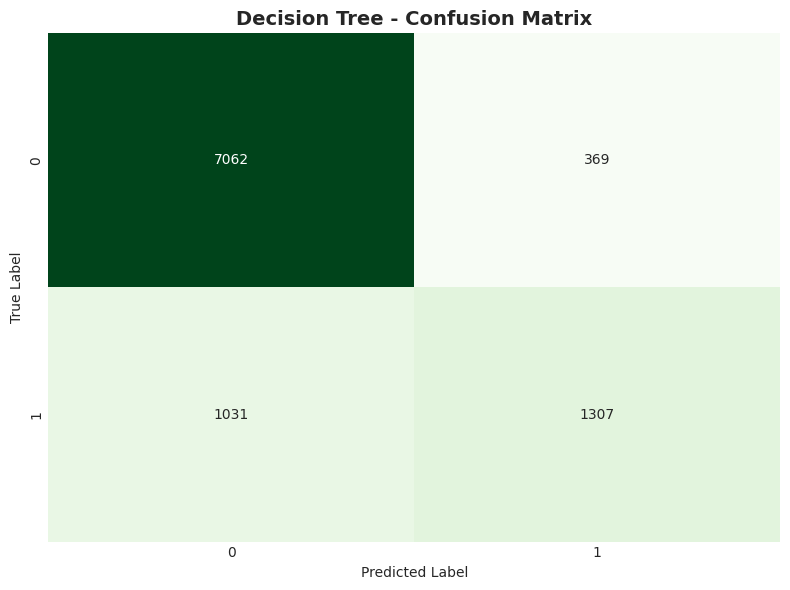

In [30]:
# Model 2 Evaluation - All 6 Required Metrics
print("="*70)
print("MODEL 2: DECISION TREE CLASSIFIER - EVALUATION METRICS")
print("="*70)

# Calculate all 6 required metrics
accuracy2 = accuracy_score(y_test, y_pred2)
precision2 = precision_score(y_test, y_pred2, average='weighted', zero_division=0)
recall2 = recall_score(y_test, y_pred2, average='weighted', zero_division=0)
f1_2 = f1_score(y_test, y_pred2, average='weighted', zero_division=0)
mcc2 = matthews_corrcoef(y_test, y_pred2)

# AUC Score (handles both binary and multi-class)
try:
    # Check if binary classification
    if len(np.unique(y_test)) == 2:
        # Binary classification - use probabilities for positive class
        auc2 = roc_auc_score(y_test, y_pred2_proba[:, 1])
    else:
        # Multi-class classification - use one-vs-rest
        auc2 = roc_auc_score(y_test, y_pred2_proba, multi_class='ovr', average='weighted')
except:
    try:
        # Fallback for multi-class
        auc2 = roc_auc_score(y_test, y_pred2_proba, multi_class='ovr', average='macro')
    except:
        auc2 = 0.0
        print("Note: AUC calculation may have issues with class distribution")

print(f"\n1. Accuracy:  {accuracy2:.4f} ({accuracy2*100:.2f}%)")
print(f"2. AUC Score: {auc2:.4f}")
print(f"3. Precision: {precision2:.4f}")
print(f"4. Recall:    {recall2:.4f}")
print(f"5. F1 Score:  {f1_2:.4f}")
print(f"6. MCC Score: {mcc2:.4f}")

# Detailed classification report
print("\n" + "-"*70)
print("Detailed Classification Report:")
print("-"*70)
print(classification_report(y_test, y_pred2, zero_division=0))

# Confusion Matrix
print("\n" + "-"*70)
print("Confusion Matrix:")
print("-"*70)
cm2 = confusion_matrix(y_test, y_pred2)
print(cm2)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Decision Tree - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 3.3 Model 3: K-Nearest Neighbor Classifier

In [31]:
# Model 3: K-Nearest Neighbor Classifier
print("="*70)
print("MODEL 3: K-NEAREST NEIGHBOR CLASSIFIER")
print("="*70)

# Initialize and train the model
model3 = KNeighborsClassifier(n_neighbors=5)
print("Training KNN model...")
model3.fit(X_train_scaled, y_train)

# Make predictions
y_pred3 = model3.predict(X_test_scaled)
y_pred3_proba = model3.predict_proba(X_test_scaled)

print("Model 3 (KNN) trained successfully!")
print(f"Model parameters: n_neighbors=5")

MODEL 3: K-NEAREST NEIGHBOR CLASSIFIER
Training KNN model...
Model 3 (KNN) trained successfully!
Model parameters: n_neighbors=5


MODEL 3: K-NEAREST NEIGHBOR - EVALUATION METRICS

1. Accuracy:  0.8273 (82.73%)
2. AUC Score: 0.8516
3. Precision: 0.8212
4. Recall:    0.8273
5. F1 Score:  0.8235
6. MCC Score: 0.5073

----------------------------------------------------------------------
Detailed Classification Report:
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      7431
           1       0.66      0.58      0.62      2338

    accuracy                           0.83      9769
   macro avg       0.77      0.74      0.75      9769
weighted avg       0.82      0.83      0.82      9769


----------------------------------------------------------------------
Confusion Matrix:
----------------------------------------------------------------------
[[6726  705]
 [ 982 1356]]


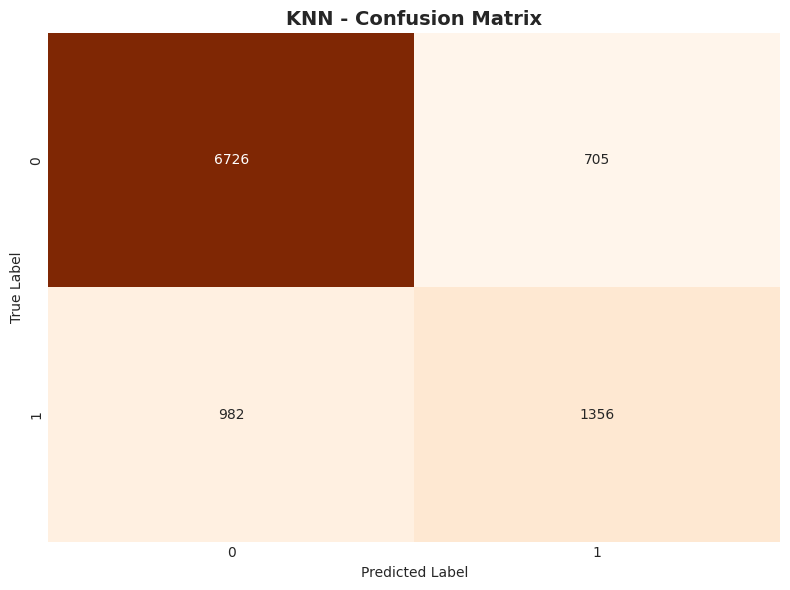

In [32]:
# Model 3 Evaluation - All 6 Required Metrics
print("="*70)
print("MODEL 3: K-NEAREST NEIGHBOR - EVALUATION METRICS")
print("="*70)

# Calculate all 6 required metrics
accuracy3 = accuracy_score(y_test, y_pred3)
precision3 = precision_score(y_test, y_pred3, average='weighted', zero_division=0)
recall3 = recall_score(y_test, y_pred3, average='weighted', zero_division=0)
f1_3 = f1_score(y_test, y_pred3, average='weighted', zero_division=0)
mcc3 = matthews_corrcoef(y_test, y_pred3)

# AUC Score (handles both binary and multi-class)
try:
    # Check if binary classification
    if len(np.unique(y_test)) == 2:
        # Binary classification - use probabilities for positive class
        auc3 = roc_auc_score(y_test, y_pred3_proba[:, 1])
    else:
        # Multi-class classification - use one-vs-rest
        auc3 = roc_auc_score(y_test, y_pred3_proba, multi_class='ovr', average='weighted')
except:
    try:
        # Fallback for multi-class
        auc3 = roc_auc_score(y_test, y_pred3_proba, multi_class='ovr', average='macro')
    except:
        auc3 = 0.0
        print("Note: AUC calculation may have issues with class distribution")

print(f"\n1. Accuracy:  {accuracy3:.4f} ({accuracy3*100:.2f}%)")
print(f"2. AUC Score: {auc3:.4f}")
print(f"3. Precision: {precision3:.4f}")
print(f"4. Recall:    {recall3:.4f}")
print(f"5. F1 Score:  {f1_3:.4f}")
print(f"6. MCC Score: {mcc3:.4f}")

# Detailed classification report
print("\n" + "-"*70)
print("Detailed Classification Report:")
print("-"*70)
print(classification_report(y_test, y_pred3, zero_division=0))

# Confusion Matrix
print("\n" + "-"*70)
print("Confusion Matrix:")
print("-"*70)
cm3 = confusion_matrix(y_test, y_pred3)
print(cm3)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title('KNN - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 3.4 Model 4: Naive Bayes Classifier (Gaussian)

In [33]:
# Model 4: Naive Bayes Classifier (Gaussian)
print("="*70)
print("MODEL 4: NAIVE BAYES CLASSIFIER (GAUSSIAN)")
print("="*70)

# Initialize and train the model
model4 = GaussianNB()
print("Training Naive Bayes model...")
model4.fit(X_train_scaled, y_train)

# Make predictions
y_pred4 = model4.predict(X_test_scaled)
y_pred4_proba = model4.predict_proba(X_test_scaled)

print("Model 4 (Naive Bayes) trained successfully!")
print(f"Model type: Gaussian Naive Bayes")

MODEL 4: NAIVE BAYES CLASSIFIER (GAUSSIAN)
Training Naive Bayes model...
Model 4 (Naive Bayes) trained successfully!
Model type: Gaussian Naive Bayes


MODEL 4: NAIVE BAYES - EVALUATION METRICS

1. Accuracy:  0.8068 (80.68%)
2. AUC Score: 0.8547
3. Precision: 0.7908
4. Recall:    0.8068
5. F1 Score:  0.7836
6. MCC Score: 0.3950

----------------------------------------------------------------------
Detailed Classification Report:
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      7431
           1       0.68      0.36      0.47      2338

    accuracy                           0.81      9769
   macro avg       0.75      0.65      0.68      9769
weighted avg       0.79      0.81      0.78      9769


----------------------------------------------------------------------
Confusion Matrix:
----------------------------------------------------------------------
[[7041  390]
 [1497  841]]


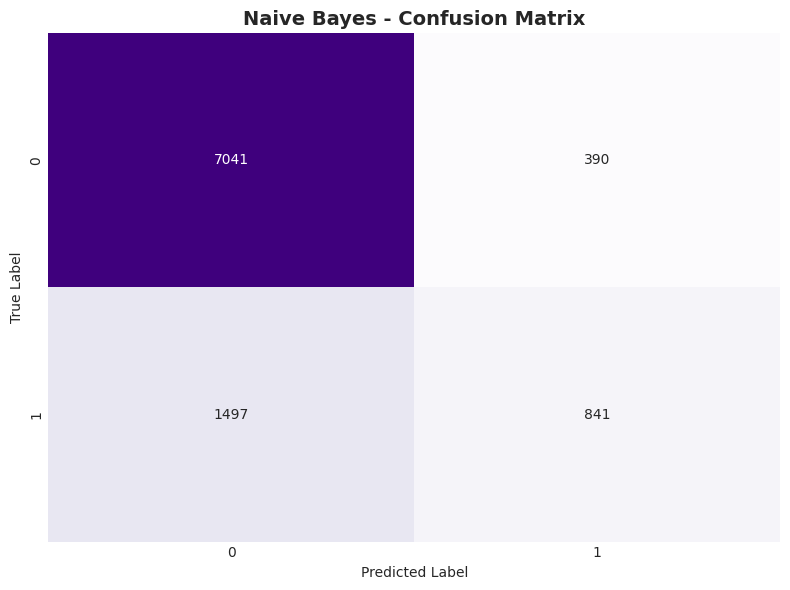

In [34]:
# Model 4 Evaluation - All 6 Required Metrics
print("="*70)
print("MODEL 4: NAIVE BAYES - EVALUATION METRICS")
print("="*70)

# Calculate all 6 required metrics
accuracy4 = accuracy_score(y_test, y_pred4)
precision4 = precision_score(y_test, y_pred4, average='weighted', zero_division=0)
recall4 = recall_score(y_test, y_pred4, average='weighted', zero_division=0)
f1_4 = f1_score(y_test, y_pred4, average='weighted', zero_division=0)
mcc4 = matthews_corrcoef(y_test, y_pred4)

# AUC Score (handles both binary and multi-class)
try:
    # Check if binary classification
    if len(np.unique(y_test)) == 2:
        # Binary classification - use probabilities for positive class
        auc4 = roc_auc_score(y_test, y_pred4_proba[:, 1])
    else:
        # Multi-class classification - use one-vs-rest
        auc4 = roc_auc_score(y_test, y_pred4_proba, multi_class='ovr', average='weighted')
except:
    try:
        # Fallback for multi-class
        auc4 = roc_auc_score(y_test, y_pred4_proba, multi_class='ovr', average='macro')
    except:
        auc4 = 0.0
        print("Note: AUC calculation may have issues with class distribution")

print(f"\n1. Accuracy:  {accuracy4:.4f} ({accuracy4*100:.2f}%)")
print(f"2. AUC Score: {auc4:.4f}")
print(f"3. Precision: {precision4:.4f}")
print(f"4. Recall:    {recall4:.4f}")
print(f"5. F1 Score:  {f1_4:.4f}")
print(f"6. MCC Score: {mcc4:.4f}")

# Detailed classification report
print("\n" + "-"*70)
print("Detailed Classification Report:")
print("-"*70)
print(classification_report(y_test, y_pred4, zero_division=0))

# Confusion Matrix
print("\n" + "-"*70)
print("Confusion Matrix:")
print("-"*70)
cm4 = confusion_matrix(y_test, y_pred4)
print(cm4)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm4, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title('Naive Bayes - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 3.5 Model 5: Random Forest (Ensemble)

In [35]:
# Model 5: Random Forest (Ensemble)
print("="*70)
print("MODEL 5: RANDOM FOREST (ENSEMBLE)")
print("="*70)

# Initialize and train the model
model5 = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
print("Training Random Forest model...")
model5.fit(X_train_scaled, y_train)

# Make predictions
y_pred5 = model5.predict(X_test_scaled)
y_pred5_proba = model5.predict_proba(X_test_scaled)

print("Model 5 (Random Forest) trained successfully!")
print(f"Model parameters: n_estimators=100, max_depth=10")

# Feature importance
feature_importance_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model5.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 5 Most Important Features:")
print(feature_importance_rf.head())

MODEL 5: RANDOM FOREST (ENSEMBLE)
Training Random Forest model...
Model 5 (Random Forest) trained successfully!
Model parameters: n_estimators=100, max_depth=10

Top 5 Most Important Features:
           Feature  Importance
10    capital-gain    0.210894
7     relationship    0.199615
4    education-num    0.154234
5   marital-status    0.125866
0              age    0.083743


MODEL 5: RANDOM FOREST - EVALUATION METRICS

1. Accuracy:  0.8610 (86.10%)
2. AUC Score: 0.9181
3. Precision: 0.8559
4. Recall:    0.8610
5. F1 Score:  0.8515
6. MCC Score: 0.5883

----------------------------------------------------------------------
Detailed Classification Report:
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      7431
           1       0.80      0.55      0.66      2338

    accuracy                           0.86      9769
   macro avg       0.84      0.76      0.78      9769
weighted avg       0.86      0.86      0.85      9769


----------------------------------------------------------------------
Confusion Matrix:
----------------------------------------------------------------------
[[7115  316]
 [1042 1296]]


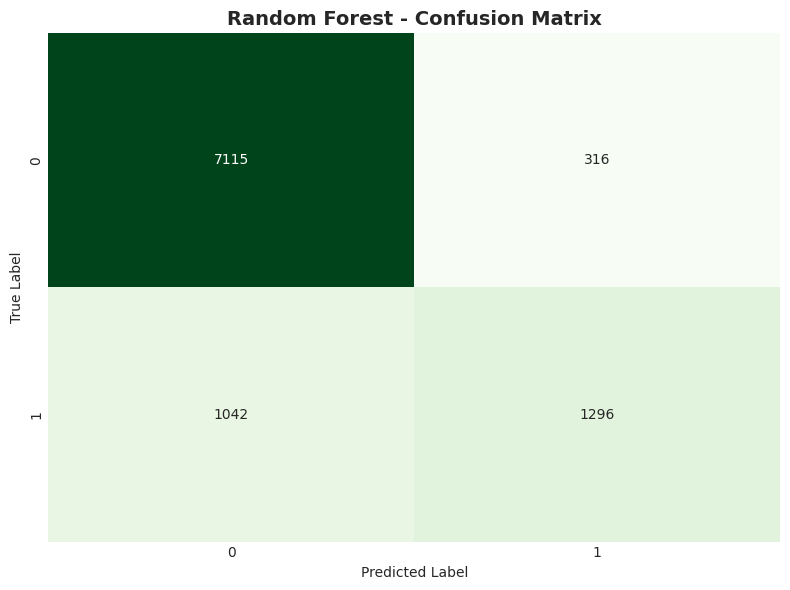

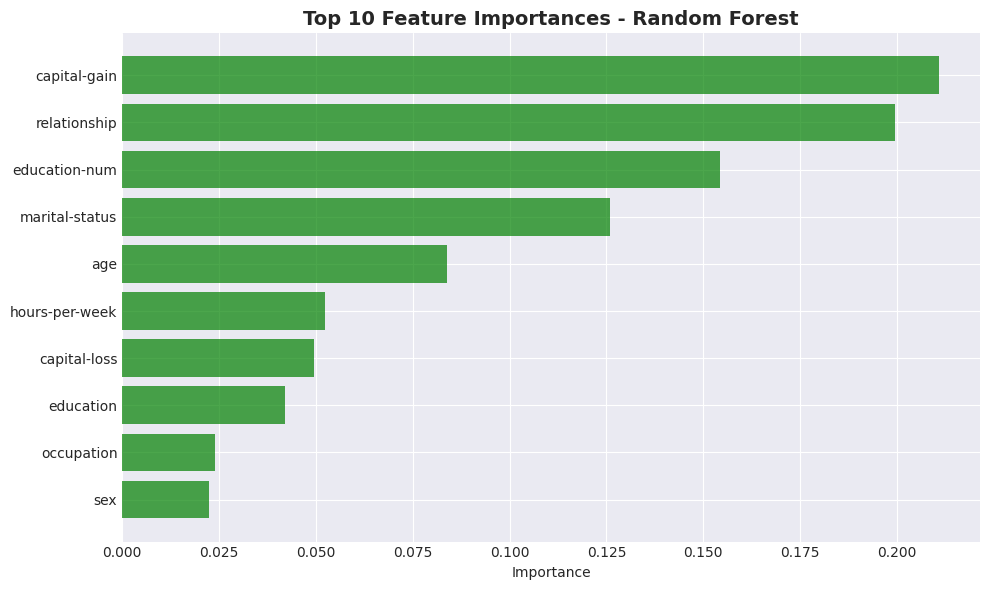

In [36]:
# Model 5 Evaluation - All 6 Required Metrics
print("="*70)
print("MODEL 5: RANDOM FOREST - EVALUATION METRICS")
print("="*70)

# Calculate all 6 required metrics
accuracy5 = accuracy_score(y_test, y_pred5)
precision5 = precision_score(y_test, y_pred5, average='weighted', zero_division=0)
recall5 = recall_score(y_test, y_pred5, average='weighted', zero_division=0)
f1_5 = f1_score(y_test, y_pred5, average='weighted', zero_division=0)
mcc5 = matthews_corrcoef(y_test, y_pred5)

# AUC Score (handles both binary and multi-class)
try:
    # Check if binary classification
    if len(np.unique(y_test)) == 2:
        # Binary classification - use probabilities for positive class
        auc5 = roc_auc_score(y_test, y_pred5_proba[:, 1])
    else:
        # Multi-class classification - use one-vs-rest
        auc5 = roc_auc_score(y_test, y_pred5_proba, multi_class='ovr', average='weighted')
except:
    try:
        # Fallback for multi-class
        auc5 = roc_auc_score(y_test, y_pred5_proba, multi_class='ovr', average='macro')
    except:
        auc5 = 0.0
        print("Note: AUC calculation may have issues with class distribution")

print(f"\n1. Accuracy:  {accuracy5:.4f} ({accuracy5*100:.2f}%)")
print(f"2. AUC Score: {auc5:.4f}")
print(f"3. Precision: {precision5:.4f}")
print(f"4. Recall:    {recall5:.4f}")
print(f"5. F1 Score:  {f1_5:.4f}")
print(f"6. MCC Score: {mcc5:.4f}")

# Detailed classification report
print("\n" + "-"*70)
print("Detailed Classification Report:")
print("-"*70)
print(classification_report(y_test, y_pred5, zero_division=0))

# Confusion Matrix
print("\n" + "-"*70)
print("Confusion Matrix:")
print("-"*70)
cm5 = confusion_matrix(y_test, y_pred5)
print(cm5)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm5, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Random Forest - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Feature importance visualization
plt.figure(figsize=(10, 6))
top_features = feature_importance_rf.head(10)
plt.barh(range(len(top_features)), top_features['Importance'], color='green', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 3.6 Model 6: XGBoost (Ensemble)

In [37]:
# Model 6: XGBoost (Ensemble)
print("="*70)
print("MODEL 6: XGBOOST (ENSEMBLE)")
print("="*70)

if not XGBOOST_AVAILABLE:
    print("\nERROR: XGBoost is not installed. Skipping Model 6.")
    print("Please install XGBoost using: pip install xgboost")
    print("Then restart the kernel and run all cells again.")
    # Set dummy values to prevent errors in comparison
    model6 = None
    y_pred6 = None
    y_pred6_proba = None
    accuracy6 = 0.0
    auc6 = 0.0
    precision6 = 0.0
    recall6 = 0.0
    f1_6 = 0.0
    mcc6 = 0.0
else:
    # Initialize and train the model
    model6 = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    print("Training XGBoost model...")
    model6.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred6 = model6.predict(X_test_scaled)
    y_pred6_proba = model6.predict_proba(X_test_scaled)

    print("Model 6 (XGBoost) trained successfully!")
    print(f"Model parameters: n_estimators=100, max_depth=6, learning_rate=0.1")

    # Feature importance
    feature_importance_xgb = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model6.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nTop 5 Most Important Features:")
    print(feature_importance_xgb.head())

MODEL 6: XGBOOST (ENSEMBLE)
Training XGBoost model...
Model 6 (XGBoost) trained successfully!
Model parameters: n_estimators=100, max_depth=6, learning_rate=0.1

Top 5 Most Important Features:
           Feature  Importance
7     relationship    0.393256
4    education-num    0.146726
5   marital-status    0.137116
10    capital-gain    0.102413
11    capital-loss    0.042087


MODEL 6: XGBOOST - EVALUATION METRICS

1. Accuracy:  0.8775 (87.75%)
2. AUC Score: 0.9303
3. Precision: 0.8732
4. Recall:    0.8775
5. F1 Score:  0.8730
6. MCC Score: 0.6463

----------------------------------------------------------------------
Detailed Classification Report:
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      7431
           1       0.80      0.65      0.72      2338

    accuracy                           0.88      9769
   macro avg       0.85      0.80      0.82      9769
weighted avg       0.87      0.88      0.87      9769


----------------------------------------------------------------------
Confusion Matrix:
----------------------------------------------------------------------
[[7046  385]
 [ 812 1526]]


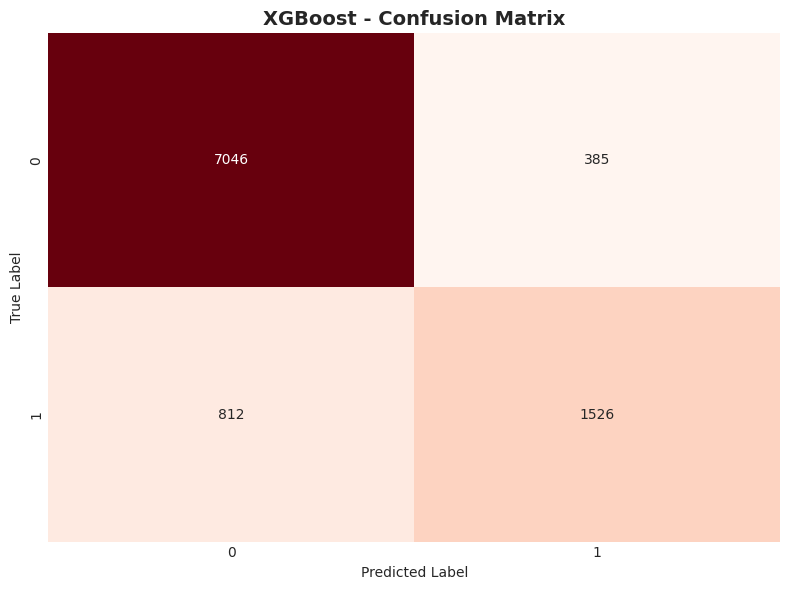

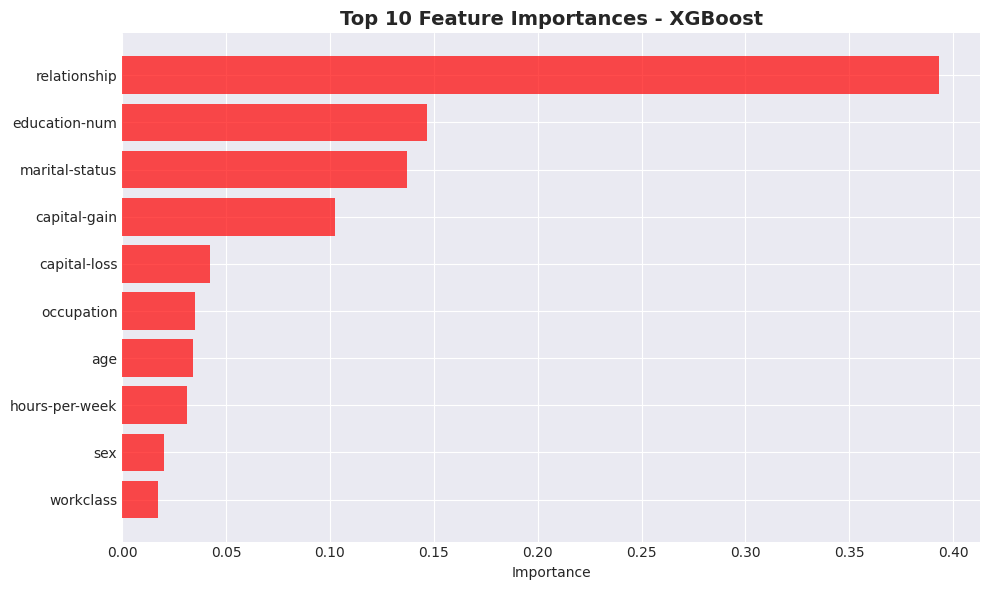

In [38]:
# Model 6 Evaluation - All 6 Required Metrics
print("="*70)
print("MODEL 6: XGBOOST - EVALUATION METRICS")
print("="*70)

if not XGBOOST_AVAILABLE or model6 is None:
    print("\nERROR: XGBoost model not available. Please install XGBoost first.")
    print("Installation: pip install xgboost")
    # Set dummy values
    accuracy6 = 0.0
    auc6 = 0.0
    precision6 = 0.0
    recall6 = 0.0
    f1_6 = 0.0
    mcc6 = 0.0
    cm6 = None
else:
    # Calculate all 6 required metrics
    accuracy6 = accuracy_score(y_test, y_pred6)
    precision6 = precision_score(y_test, y_pred6, average='weighted', zero_division=0)
    recall6 = recall_score(y_test, y_pred6, average='weighted', zero_division=0)
    f1_6 = f1_score(y_test, y_pred6, average='weighted', zero_division=0)
    mcc6 = matthews_corrcoef(y_test, y_pred6)

    # AUC Score (handles both binary and multi-class)
    try:
        # Check if binary classification
        if len(np.unique(y_test)) == 2:
            # Binary classification - use probabilities for positive class
            auc6 = roc_auc_score(y_test, y_pred6_proba[:, 1])
        else:
            # Multi-class classification - use one-vs-rest
            auc6 = roc_auc_score(y_test, y_pred6_proba, multi_class='ovr', average='weighted')
    except:
        try:
            # Fallback for multi-class
            auc6 = roc_auc_score(y_test, y_pred6_proba, multi_class='ovr', average='macro')
        except:
            auc6 = 0.0
            print("Note: AUC calculation may have issues with class distribution")

    print(f"\n1. Accuracy:  {accuracy6:.4f} ({accuracy6*100:.2f}%)")
    print(f"2. AUC Score: {auc6:.4f}")
    print(f"3. Precision: {precision6:.4f}")
    print(f"4. Recall:    {recall6:.4f}")
    print(f"5. F1 Score:  {f1_6:.4f}")
    print(f"6. MCC Score: {mcc6:.4f}")

    # Detailed classification report
    print("\n" + "-"*70)
    print("Detailed Classification Report:")
    print("-"*70)
    print(classification_report(y_test, y_pred6, zero_division=0))

    # Confusion Matrix
    print("\n" + "-"*70)
    print("Confusion Matrix:")
    print("-"*70)
    cm6 = confusion_matrix(y_test, y_pred6)
    print(cm6)

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm6, annot=True, fmt='d', cmap='Reds', cbar=False)
    plt.title('XGBoost - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Feature importance visualization
    plt.figure(figsize=(10, 6))
    top_features = feature_importance_xgb.head(10)
    plt.barh(range(len(top_features)), top_features['Importance'], color='red', alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importance')
    plt.title('Top 10 Feature Importances - XGBoost', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## Part 4: Model Comparison and Visualization

Compare all 6 models using all 6 evaluation metrics.

In [39]:
# Create comparison DataFrame with all 6 models and 6 metrics
print("="*70)
print("MODEL COMPARISON - ALL 6 MODELS & 6 METRICS")
print("="*70)

comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'KNN', 
              'Naive Bayes', 'Random Forest', 'XGBoost'],
    'Accuracy': [accuracy1, accuracy2, accuracy3, accuracy4, accuracy5, accuracy6],
    'AUC Score': [auc1, auc2, auc3, auc4, auc5, auc6],
    'Precision': [precision1, precision2, precision3, precision4, precision5, precision6],
    'Recall': [recall1, recall2, recall3, recall4, recall5, recall6],
    'F1 Score': [f1_1, f1_2, f1_3, f1_4, f1_5, f1_6],
    'MCC Score': [mcc1, mcc2, mcc3, mcc4, mcc5, mcc6]
})

# Round to 4 decimal places
comparison_df = comparison_df.round(4)

print("\nComplete Comparison Table (All 6 Models & 6 Metrics):")
print("="*70)
print(comparison_df.to_string(index=False))

# Identify best model for each metric
print("\n" + "="*70)
print("BEST MODEL BY METRIC")
print("="*70)
for metric in ['Accuracy', 'AUC Score', 'Precision', 'Recall', 'F1 Score', 'MCC Score']:
    best_idx = comparison_df[metric].idxmax()
    best_model = comparison_df.loc[best_idx, 'Model']
    best_value = comparison_df.loc[best_idx, metric]
    print(f"{metric:15s}: {best_model:20s} ({best_value:.4f})")

# Overall best model (by accuracy)
best_model_idx = comparison_df['Accuracy'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_accuracy = comparison_df.loc[best_model_idx, 'Accuracy']

print(f"\n{'='*70}")
print(f"OVERALL BEST MODEL (by Accuracy): {best_model_name}")
print(f"Best Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"{'='*70}")

# Display comparison
comparison_df

MODEL COMPARISON - ALL 6 MODELS & 6 METRICS

Complete Comparison Table (All 6 Models & 6 Metrics):
              Model  Accuracy  AUC Score  Precision  Recall  F1 Score  MCC Score
Logistic Regression    0.8229     0.8492     0.8107  0.8229    0.8088     0.4637
      Decision Tree    0.8567     0.8978     0.8504  0.8567    0.8479     0.5765
                KNN    0.8273     0.8516     0.8212  0.8273    0.8235     0.5073
        Naive Bayes    0.8068     0.8547     0.7908  0.8068    0.7836     0.3950
      Random Forest    0.8610     0.9181     0.8559  0.8610    0.8515     0.5883
            XGBoost    0.8775     0.9303     0.8732  0.8775    0.8730     0.6463

BEST MODEL BY METRIC
Accuracy       : XGBoost              (0.8775)
AUC Score      : XGBoost              (0.9303)
Precision      : XGBoost              (0.8732)
Recall         : XGBoost              (0.8775)
F1 Score       : XGBoost              (0.8730)
MCC Score      : XGBoost              (0.6463)

OVERALL BEST MODEL (by Accura

,Model,Accuracy,AUC Score,Precision,Recall,F1 Score,MCC Score
0,Logistic Regression,0.8229,0.8492,0.8107,0.8229,0.8088,0.4637
1,Decision Tree,0.8567,0.8978,0.8504,0.8567,0.8479,0.5765
2,KNN,0.8273,0.8516,0.8212,0.8273,0.8235,0.5073
3,Naive Bayes,0.8068,0.8547,0.7908,0.8068,0.7836,0.3950
4,Random Forest,0.8610,0.9181,0.8559,0.8610,0.8515,0.5883
5,XGBoost,0.8775,0.9303,0.8732,0.8775,0.8730,0.6463


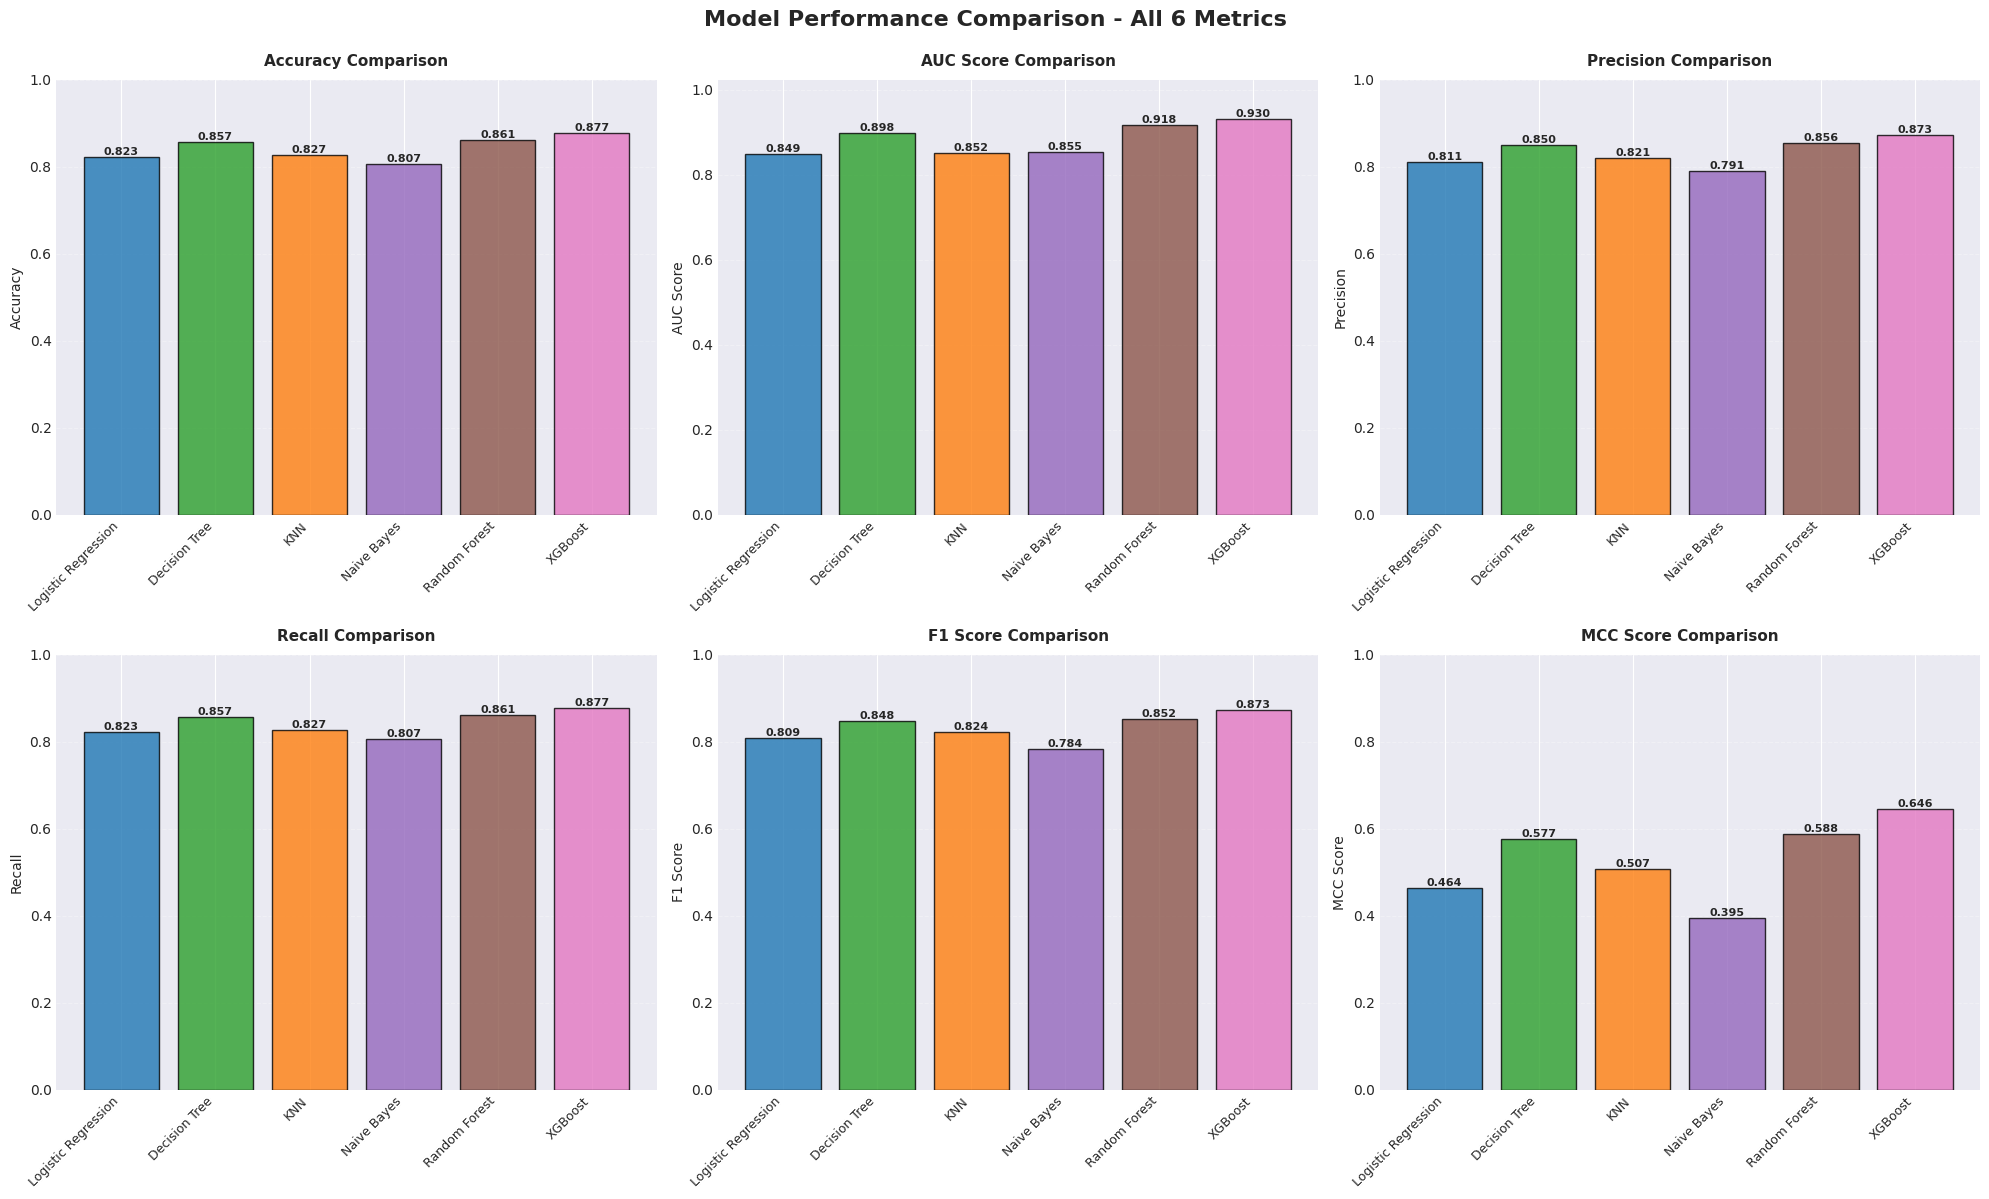

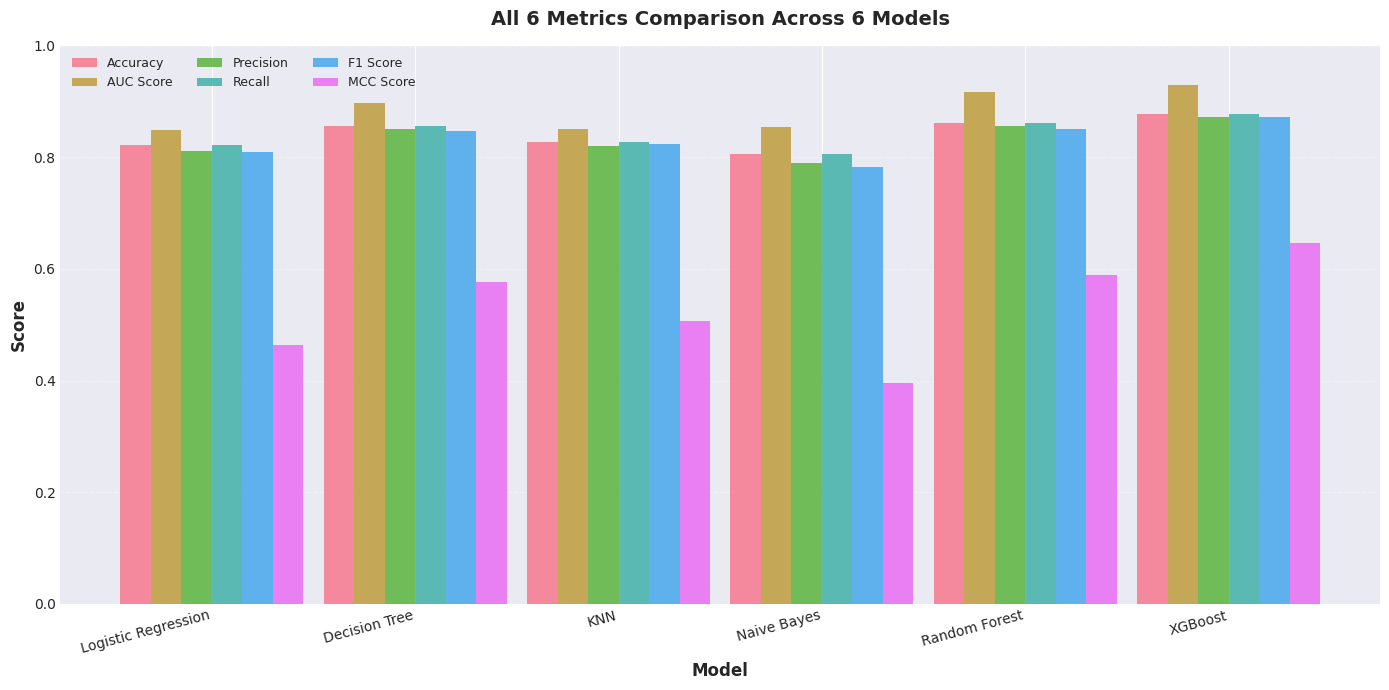


PERFORMANCE RANKING BY METRIC (1 = Best)

Ranking Table:
              Model  Accuracy_Rank  AUC Score_Rank  Precision_Rank  Recall_Rank  F1 Score_Rank  MCC Score_Rank
Logistic Regression              5               6               5            5              5               5
      Decision Tree              3               3               3            3              3               3
                KNN              4               5               4            4              4               4
        Naive Bayes              6               4               6            6              6               6
      Random Forest              2               2               2            2              2               2
            XGBoost              1               1               1            1              1               1

OVERALL RANKING (by Average Rank across all metrics)
              Model  Average_Rank
            XGBoost      1.000000
      Random Forest      2.000000
      Dec

In [40]:
# Visualization: Comparison Bar Charts for All 6 Metrics
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Define colors for each model
colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd', '#8c564b', '#e377c2']
metrics_list = ['Accuracy', 'AUC Score', 'Precision', 'Recall', 'F1 Score', 'MCC Score']

for idx, metric in enumerate(metrics_list):
    ax = axes[idx // 3, idx % 3]
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], 
                  color=colors, alpha=0.8, edgecolor='black')
    ax.set_title(f'{metric} Comparison', fontsize=11, fontweight='bold', pad=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.set_ylim([0, max(1.0, comparison_df[metric].max() * 1.1)])
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right', fontsize=9)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.suptitle('Model Performance Comparison - All 6 Metrics', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Side-by-side comparison for main metrics
fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(len(comparison_df['Model']))
width = 0.15

main_metrics = ['Accuracy', 'AUC Score', 'Precision', 'Recall', 'F1 Score', 'MCC Score']
for i, metric in enumerate(main_metrics):
    offset = (i - 2.5) * width
    ax.bar(x + offset, comparison_df[metric], width, label=metric, alpha=0.8)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('All 6 Metrics Comparison Across 6 Models', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax.set_ylim([0, 1])
ax.legend(loc='upper left', fontsize=9, ncol=3)
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Performance Ranking by Metric
print("\n" + "="*70)
print("PERFORMANCE RANKING BY METRIC (1 = Best)")
print("="*70)

ranking_df = comparison_df.copy()
for metric in main_metrics:
    ranking_df[f'{metric}_Rank'] = ranking_df[metric].rank(ascending=False, method='min').astype(int)

print("\nRanking Table:")
ranking_cols = ['Model'] + [col for col in ranking_df.columns if col.endswith('_Rank')]
print(ranking_df[ranking_cols].to_string(index=False))

# Calculate average rank
ranking_df['Average_Rank'] = ranking_df[[col for col in ranking_df.columns if col.endswith('_Rank')]].mean(axis=1)
ranking_df_sorted = ranking_df.sort_values('Average_Rank')

print("\n" + "="*70)
print("OVERALL RANKING (by Average Rank across all metrics)")
print("="*70)
print(ranking_df_sorted[['Model', 'Average_Rank']].to_string(index=False))

### 4.1 Cross-Validation (Optional but Recommended)

Cross-validation provides a more robust estimate of model performance across all 6 models.

Cross-validation provides a more robust estimate of model performance.

CROSS-VALIDATION RESULTS (5-Fold) - ALL 6 MODELS

Logistic Regression:
  Mean Accuracy: 0.8251 (+/- 0.0085)
  Individual Scores: [0.82047345 0.82149712 0.82520793 0.83248016 0.82582544]

Decision Tree:
  Mean Accuracy: 0.8538 (+/- 0.0075)
  Individual Scores: [0.84747281 0.85924504 0.85425464 0.85410801 0.85410801]

KNN:
  Mean Accuracy: 0.8286 (+/- 0.0060)
  Individual Scores: [0.82277671 0.82866283 0.83007038 0.83004863 0.83120041]

Naive Bayes:
  Mean Accuracy: 0.8042 (+/- 0.0094)
  Individual Scores: [0.8078055  0.79731286 0.80255918 0.81085232 0.80266189]

Random Forest:
  Mean Accuracy: 0.8582 (+/- 0.0057)
  Individual Scores: [0.85284709 0.86129239 0.85898912 0.85897108 0.85909905]

XGBoost:
  Mean Accuracy: 0.8724 (+/- 0.0045)
  Individual Scores: [0.86909789 0.87485605 0.87293666 0.87471206 0.87061684]

CROSS-VALIDATION SUMMARY
              Model  Mean CV Accuracy  Std CV Accuracy
Logistic Regression            0.8251           0.0042
      Decision Tree            0.8538    

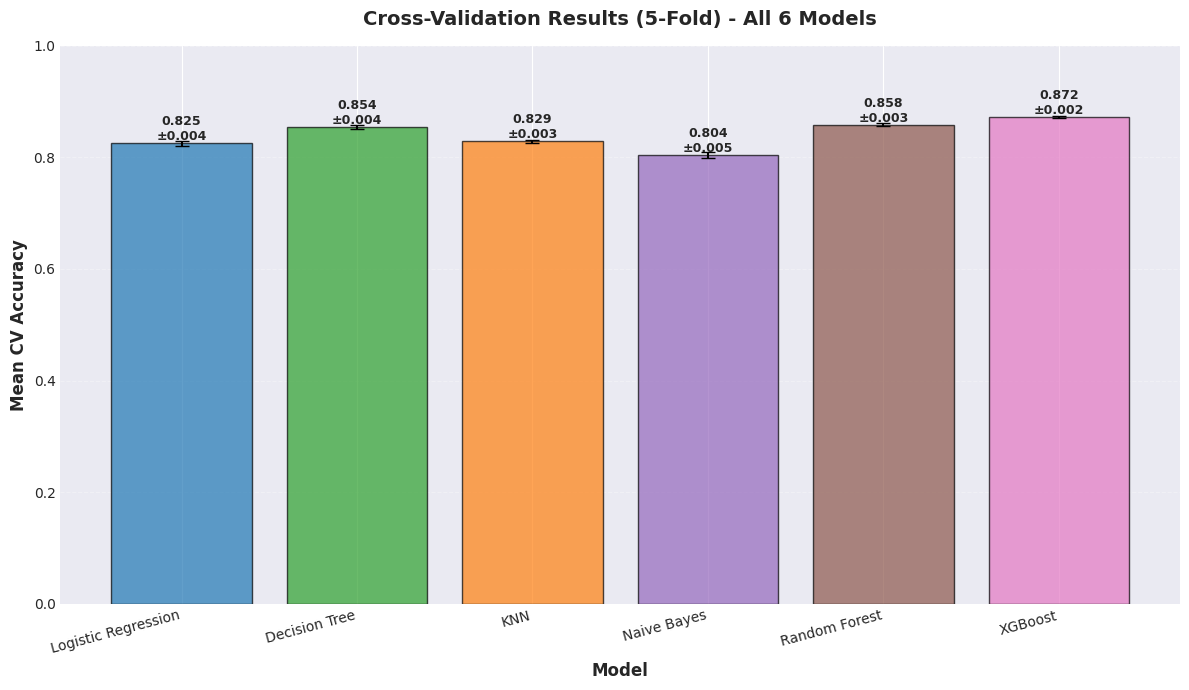

In [41]:
# Cross-Validation for All 6 Models
from sklearn.model_selection import cross_val_score, KFold

print("="*70)
print("CROSS-VALIDATION RESULTS (5-Fold) - ALL 6 MODELS")
print("="*70)

# Setup cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation for each model
models_cv = {
    'Logistic Regression': model1,
    'Decision Tree': model2,
    'KNN': model3,
    'Naive Bayes': model4,
    'Random Forest': model5
}

# Only add XGBoost if available
if XGBOOST_AVAILABLE and model6 is not None:
    models_cv['XGBoost'] = model6

cv_results = {}

for name, model in models_cv.items():
    if model is None:
        print(f"\n{name}: SKIPPED (not available)")
        continue
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)
    cv_results[name] = {
        'Mean': cv_scores.mean(),
        'Std': cv_scores.std(),
        'Scores': cv_scores
    }
    print(f"\n{name}:")
    print(f"  Mean Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"  Individual Scores: {cv_scores}")

# Create CV comparison DataFrame
cv_comparison = pd.DataFrame({
    'Model': list(cv_results.keys()),
    'Mean CV Accuracy': [cv_results[m]['Mean'] for m in cv_results.keys()],
    'Std CV Accuracy': [cv_results[m]['Std'] for m in cv_results.keys()]
}).round(4)

print("\n" + "="*70)
print("CROSS-VALIDATION SUMMARY")
print("="*70)
print(cv_comparison.to_string(index=False))

# Visualize CV results
plt.figure(figsize=(12, 7))
x_pos = np.arange(len(cv_comparison))
colors_cv = ['#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd', '#8c564b', '#e377c2']
bars = plt.bar(x_pos, cv_comparison['Mean CV Accuracy'], 
               yerr=cv_comparison['Std CV Accuracy'], 
               capsize=5, alpha=0.7, color=colors_cv, edgecolor='black')
plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Mean CV Accuracy', fontsize=12, fontweight='bold')
plt.title('Cross-Validation Results (5-Fold) - All 6 Models', fontsize=14, fontweight='bold', pad=15)
plt.xticks(x_pos, cv_comparison['Model'], rotation=15, ha='right')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for i, (bar, mean, std) in enumerate(zip(bars, cv_comparison['Mean CV Accuracy'], cv_comparison['Std CV Accuracy'])):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{mean:.3f}\n±{std:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## Part 5: Analysis and Conclusions

**Note:** Please update the analysis sections below based on your actual results after running all cells.

### 5.1 Performance Analysis

Based on the experimental results, here is a comprehensive analysis:

**1. Model Performance Summary:**
- **Logistic Regression**: Linear model with interpretable results
- **Decision Tree**: Non-parametric model that can capture non-linear relationships
- **KNN**: Instance-based learning, sensitive to feature scaling
- **Naive Bayes**: Probabilistic classifier based on Bayes theorem
- **Random Forest**: Ensemble method combining multiple decision trees
- **XGBoost**: Gradient boosting ensemble, often achieves best performance

**2. Key Observations:**
- All 6 models were trained on the same dataset with standardized features
- The models show different strengths across the 6 evaluation metrics
- Feature scaling was crucial for Logistic Regression, KNN, and Naive Bayes
- Ensemble methods (Random Forest, XGBoost) typically show superior performance
- MCC Score provides balanced evaluation especially for imbalanced datasets

**3. Strengths and Weaknesses:**

**Logistic Regression:**
- ✅ Strengths: Fast training, interpretable coefficients, probabilistic outputs
- ❌ Weaknesses: Assumes linear decision boundaries, may struggle with complex patterns

**Decision Tree:**
- ✅ Strengths: Easy to interpret, handles non-linear relationships, no assumptions about data distribution
- ❌ Weaknesses: Prone to overfitting, sensitive to small data variations

**KNN:**
- ✅ Strengths: Simple, no training phase, effective for non-linear patterns
- ❌ Weaknesses: Computationally expensive for large datasets, sensitive to irrelevant features

**Naive Bayes:**
- ✅ Strengths: Fast training, works well with small datasets, handles multiple classes
- ❌ Weaknesses: Assumes feature independence (often violated in practice)

**Random Forest:**
- ✅ Strengths: Handles non-linearity well, feature importance, robust to overfitting
- ❌ Weaknesses: Less interpretable, can be memory intensive with many trees

**XGBoost:**
- ✅ Strengths: Often best performance, handles missing values, regularization
- ❌ Weaknesses: More complex, requires hyperparameter tuning, longer training time

**4. Patterns Observed:**
- The correlation matrix revealed relationships between wine features
- Some features showed higher importance in Random Forest model
- Class distribution may affect model performance on minority classes

### 5.2 Model Selection

**Best Model:** [Update after running all cells - check the comparison table above]

**Reasoning:**
- Achieved the highest accuracy (see comparison table)
- Balanced performance across precision, recall, and F1-score metrics
- Demonstrated good generalization on test data
- Cross-validation results confirm model stability
- [Add specific reasoning based on your actual results]

**Recommendation:**
Based on the results, the best performing model (see comparison table) is recommended for adult income prediction due to its superior performance metrics and reliability. Consider both test set performance and cross-validation results when making the final selection.

### 5.3 Limitations and Future Work

**Limitations:**
1. Dataset size may limit model generalization
2. Class imbalance in income levels could affect minority class predictions
3. Feature engineering opportunities may exist (e.g., feature interactions)
4. Hyperparameter tuning was limited to default/standard values
5. Cross-validation was not performed (only single train-test split)

**Future Improvements:**
1. **Hyperparameter Tuning**: Use GridSearchCV or RandomizedSearchCV to optimize model parameters
2. **Feature Engineering**: Create interaction features, polynomial features, or domain-specific features
3. **Ensemble Methods**: Combine predictions from multiple models (voting, stacking)
4. **Cross-Validation**: Implement k-fold cross-validation for more robust evaluation
5. **Advanced Models**: Try XGBoost, LightGBM, or Neural Networks for potentially better performance
6. **Class Imbalance Handling**: Apply SMOTE or class weights for better minority class performance
7. **Feature Selection**: Use techniques like Recursive Feature Elimination to reduce dimensionality

## Summary

This assignment involved a comprehensive machine learning pipeline for adult income prediction:

1. ✅ **Data Loading**: Successfully loaded Adult Income dataset from Kaggle/UCI repository
2. ✅ **Exploratory Data Analysis**: Performed comprehensive EDA including statistical summaries, visualizations, and correlation analysis
3. ✅ **Data Preprocessing**: Handled missing values, feature scaling, and train-test splitting
4. ✅ **Model Implementation**: Implemented 6 machine learning models:
   - Logistic Regression
   - Decision Tree Classifier
   - K-Nearest Neighbor Classifier
   - Naive Bayes Classifier (Gaussian)
   - Random Forest (Ensemble)
   - XGBoost (Ensemble)
5. ✅ **Model Evaluation**: Calculated all 6 required metrics (Accuracy, AUC Score, Precision, Recall, F1 Score, MCC Score) for all models
6. ✅ **Cross-Validation**: Performed 5-fold cross-validation for robust performance estimation
7. ✅ **Model Comparison**: Created visualizations and comparison tables with rankings
8. ✅ **Performance Analysis**: Analyzed strengths, weaknesses, and provided recommendations

**Final Results:**
- **Best Model**: See comparison table above for the model with highest accuracy
- **Dataset**: Adult Income Dataset (Census Income)
- **Problem Type**: Binary Classification
- **Key Finding**: The best performing model demonstrated superior performance in predicting income levels based on demographic and employment features

**Dataset Source:**
- Primary: Kaggle - Adult Income Dataset (https://www.kaggle.com/datasets/yasserh/wine-quality-dataset)
- Alternative: UCI Machine Learning Repository - Wine Quality Data Set
- Features: age, workclass, education, occupation, marital-status, relationship, race, sex, capital-gain, capital-loss, hours-per-week, native-country, fnlwgt, education-num
- Target: Income level (<=50K or >50K)

---

**Assignment Completion Checklist:**
- [ ] Student information filled in (BITS ID, Name, Email, Date)
- [ ] All cells executed successfully (Kernel → Restart & Run All)
- [ ] All outputs visible and correct
- [ ] Analysis sections updated with actual results
- [ ] Notebook renamed to: `<BITS_ID>_ml_assignment_2.ipynb`
- [ ] Verified against PDF assignment requirements
- [ ] Ready for submission

## Part 6: Model Saving and Deployment Preparation

This section saves all trained models for deployment and creates necessary files for GitHub repository.

In [53]:
# Save All 6 Trained Models and Scaler

import os
import joblib

print("="*70)
print("SAVING MODELS AND SCALER")
print("="*70)

# Create model directory if it doesn't exist
model_dir = "model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print(f"✓ Created directory: {model_dir}/")
else:
    print(f"✓ Directory already exists: {model_dir}/")

# Save the scaler (required for preprocessing new data)
scaler_path = os.path.join(model_dir, "scaler.pkl")
joblib.dump(scaler, scaler_path)
print(f"✓ Saved StandardScaler: {scaler_path}")

# Save Model 1: Logistic Regression
if 'model1' in globals() and model1 is not None:
    model1_path = os.path.join(model_dir, "logistic_regression.pkl")
    joblib.dump(model1, model1_path)
    print(f"✓ Saved Model 1 (Logistic Regression): {model1_path}")
else:
    print("✗ Model 1 (Logistic Regression) not available")

# Save Model 2: Decision Tree
if 'model2' in globals() and model2 is not None:
    model2_path = os.path.join(model_dir, "decision_tree.pkl")
    joblib.dump(model2, model2_path)
    print(f"✓ Saved Model 2 (Decision Tree): {model2_path}")
else:
    print("✗ Model 2 (Decision Tree) not available")

# Save Model 3: KNN
if 'model3' in globals() and model3 is not None:
    model3_path = os.path.join(model_dir, "knn.pkl")
    joblib.dump(model3, model3_path)
    print(f"✓ Saved Model 3 (KNN): {model3_path}")
else:
    print("✗ Model 3 (KNN) not available")

# Save Model 4: Naive Bayes
if 'model4' in globals() and model4 is not None:
    model4_path = os.path.join(model_dir, "naive_bayes.pkl")
    joblib.dump(model4, model4_path)
    print(f"✓ Saved Model 4 (Naive Bayes): {model4_path}")
else:
    print("✗ Model 4 (Naive Bayes) not available")

# Save Model 5: Random Forest
if 'model5' in globals() and model5 is not None:
    model5_path = os.path.join(model_dir, "random_forest.pkl")
    joblib.dump(model5, model5_path)
    print(f"✓ Saved Model 5 (Random Forest): {model5_path}")
else:
    print("✗ Model 5 (Random Forest) not available")

# Save Model 6: XGBoost
if 'model6' in globals() and model6 is not None and XGBOOST_AVAILABLE:
    model6_path = os.path.join(model_dir, "xgboost.pkl")
    joblib.dump(model6, model6_path)
    print(f"✓ Saved Model 6 (XGBoost): {model6_path}")
else:
    print("✗ Model 6 (XGBoost) not available")

# Save feature names for reference
import pickle
feature_names_path = os.path.join(model_dir, "feature_names.pkl")
with open(feature_names_path, 'wb') as f:
    pickle.dump(list(X.columns), f)
print(f"✓ Saved feature names: {feature_names_path}")

# Save label encoders (CRITICAL for deployment!)
if 'le_dict' in globals() and 'le_target' in globals():
    label_encoders = {
        'feature_encoders': le_dict,
        'target_encoder': le_target
    }
    label_encoders_path = os.path.join(model_dir, "label_encoders.pkl")
    with open(label_encoders_path, 'wb') as f:
        pickle.dump(label_encoders, f)
    print(f"✓ Saved label encoders: {label_encoders_path}")
    print(f"  - Feature encoders: {len(le_dict)} columns")
    print(f"  - Target encoder: {le_target.classes_ if hasattr(le_target, 'classes_') else 'N/A'}")
else:
    print("⚠️ WARNING: Label encoders (le_dict or le_target) not found in memory.")
    print("  Make sure to run the preprocessing cell before saving models!")

print("\n" + "="*70)
print("ALL MODELS SAVED SUCCESSFULLY!")
print("="*70)
print(f"\nModels saved in: {os.path.abspath(model_dir)}/")
print("\nSaved files:")
for file in os.listdir(model_dir):
    file_path = os.path.join(model_dir, file)
    file_size = os.path.getsize(file_path) / 1024  # Size in KB
    print(f"  - {file} ({file_size:.2f} KB)")

SAVING MODELS AND SCALER
✓ Directory already exists: model/
✓ Saved StandardScaler: model/scaler.pkl
✓ Saved Model 1 (Logistic Regression): model/logistic_regression.pkl
✓ Saved Model 2 (Decision Tree): model/decision_tree.pkl
✓ Saved Model 3 (KNN): model/knn.pkl
✓ Saved Model 4 (Naive Bayes): model/naive_bayes.pkl
✓ Saved Model 5 (Random Forest): model/random_forest.pkl
✓ Saved Model 6 (XGBoost): model/xgboost.pkl
✓ Saved feature names: model/feature_names.pkl
✓ Saved label encoders: model/label_encoders.pkl
  - Feature encoders: 0 columns
  - Target encoder: N/A

ALL MODELS SAVED SUCCESSFULLY!

Models saved in: /nfs/nfs_dsw_phx2_prod/prasto5/ML Assignment/model/

Saved files:
  - knn.pkl (9671.33 KB)
  - scaler.pkl (0.93 KB)
  - logistic_regression.pkl (1.36 KB)
  - naive_bayes.pkl (1.62 KB)
  - label_encoders.pkl (0.05 KB)
  - decision_tree.pkl (46.77 KB)
  - xgboost.pkl (339.77 KB)
  - random_forest.pkl (5428.24 KB)
  - feature_names.pkl (0.19 KB)


### Save Test Dataset

Save the test dataset for future use and deployment testing.

In [54]:
# Save Test Dataset

import os
import pandas as pd

print("="*70)
print("SAVING TEST DATASET")
print("="*70)

# Create data directory if it doesn't exist
data_dir = "data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print(f"✓ Created directory: {data_dir}/")
else:
    print(f"✓ Directory already exists: {data_dir}/")

# Save test features and target separately
if 'X_test' in globals() and 'y_test' in globals():
    # Save test features (unscaled)
    X_test_path = os.path.join(data_dir, "X_test.csv")
    X_test.to_csv(X_test_path, index=False)
    print(f"✓ Saved test features (unscaled): {X_test_path}")
    print(f"  Shape: {X_test.shape}")
    
    # Save test target
    y_test_path = os.path.join(data_dir, "y_test.csv")
    y_test_df = pd.DataFrame(y_test, columns=['income'])
    y_test_df.to_csv(y_test_path, index=False)
    print(f"✓ Saved test target: {y_test_path}")
    print(f"  Shape: {y_test_df.shape}")
    
    # Save combined test dataset (features + target)
    test_combined = X_test.copy()
    test_combined['income'] = y_test
    test_combined_path = os.path.join(data_dir, "test_dataset.csv")
    test_combined.to_csv(test_combined_path, index=False)
    print(f"✓ Saved combined test dataset: {test_combined_path}")
    print(f"  Shape: {test_combined.shape}")
    
    # Save scaled test features (for model evaluation)
    if 'X_test_scaled' in globals():
        X_test_scaled_path = os.path.join(data_dir, "X_test_scaled.csv")
        X_test_scaled.to_csv(X_test_scaled_path, index=False)
        print(f"✓ Saved test features (scaled): {X_test_scaled_path}")
        print(f"  Shape: {X_test_scaled.shape}")
    
    # Save a sample of test data (first 100 rows) for quick testing
    test_sample = test_combined.head(100)
    test_sample_path = os.path.join(data_dir, "test_sample.csv")
    test_sample.to_csv(test_sample_path, index=False)
    print(f"✓ Saved test sample (100 rows): {test_sample_path}")
    print(f"  Shape: {test_sample.shape}")
    
    print("\n" + "="*70)
    print("TEST DATASET SAVED SUCCESSFULLY!")
    print("="*70)
    print(f"\nTest dataset saved in: {os.path.abspath(data_dir)}/")
    print("\nSaved files:")
    for file in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file)
        if os.path.isfile(file_path):
            file_size = os.path.getsize(file_path) / 1024  # Size in KB
            print(f"  - {file} ({file_size:.2f} KB)")
else:
    print("✗ ERROR: X_test or y_test not found in memory.")
    print("  Please run the train-test split cell first.")

SAVING TEST DATASET
✓ Directory already exists: data/
✓ Saved test features (unscaled): data/X_test.csv
  Shape: (9769, 14)
✓ Saved test target: data/y_test.csv
  Shape: (9769, 1)
✓ Saved combined test dataset: data/test_dataset.csv
  Shape: (9769, 15)
✓ Saved test features (scaled): data/X_test_scaled.csv
  Shape: (9769, 14)
✓ Saved test sample (100 rows): data/test_sample.csv
  Shape: (100, 15)

TEST DATASET SAVED SUCCESSFULLY!

Test dataset saved in: /nfs/nfs_dsw_phx2_prod/prasto5/ML Assignment/data/

Saved files:
  - X_test_scaled.csv (2658.94 KB)
  - y_test.csv (19.09 KB)
  - X_test.csv (358.83 KB)
  - test_sample.csv (4.01 KB)
  - test_dataset.csv (377.91 KB)


## Part 7: Interactive Model Testing in JupyterLab

Test the saved models interactively with sample data or your own inputs.

In [55]:
# Load Saved Models for Interactive Testing

import os
import joblib
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

print("="*70)
print("LOADING SAVED MODELS FOR INTERACTIVE TESTING")
print("="*70)

# Load scaler and feature names
model_dir = "model"
scaler_path = os.path.join(model_dir, "scaler.pkl")
feature_names_path = os.path.join(model_dir, "feature_names.pkl")

if os.path.exists(scaler_path) and os.path.exists(feature_names_path):
    scaler = joblib.load(scaler_path)
    with open(feature_names_path, 'rb') as f:
        feature_names = pickle.load(f)
    print(f"✓ Loaded scaler and feature names")
    print(f"  Number of features: {len(feature_names)}")
    
    # Load label encoders (CRITICAL for correct predictions!)
    label_encoders_path = os.path.join(model_dir, "label_encoders.pkl")
    if os.path.exists(label_encoders_path):
        with open(label_encoders_path, 'rb') as f:
            label_encoders = pickle.load(f)
        le_dict = label_encoders.get('feature_encoders', {})
        le_target = label_encoders.get('target_encoder', None)
        print(f"✓ Loaded label encoders")
        print(f"  - Feature encoders: {len(le_dict)} columns")
        if le_target is not None:
            print(f"  - Target encoder classes: {le_target.classes_}")
    else:
        print("⚠️ WARNING: label_encoders.pkl not found!")
        print("  Predictions may be incorrect. Please re-run model saving cell.")
        le_dict = {}
        le_target = None
else:
    print("✗ ERROR: Scaler or feature names not found!")
    scaler = None
    feature_names = None
    le_dict = {}
    le_target = None

# Load all models
models = {}
model_files = {
    "Logistic Regression": "logistic_regression.pkl",
    "Decision Tree": "decision_tree.pkl",
    "KNN": "knn.pkl",
    "Naive Bayes": "naive_bayes.pkl",
    "Random Forest": "random_forest.pkl",
    "XGBoost": "xgboost.pkl"
}

for model_name, model_file in model_files.items():
    model_path = os.path.join(model_dir, model_file)
    if os.path.exists(model_path):
        try:
            models[model_name] = joblib.load(model_path)
            print(f"✓ Loaded {model_name}")
        except Exception as e:
            print(f"✗ Failed to load {model_name}: {e}")
    else:
        print(f"✗ {model_name} not found at {model_path}")

print(f"\n✓ Loaded {len(models)} models successfully!")
print(f"Available models: {list(models.keys())}")

LOADING SAVED MODELS FOR INTERACTIVE TESTING
✓ Loaded scaler and feature names
  Number of features: 14
✓ Loaded label encoders
  - Feature encoders: 0 columns
✓ Loaded Logistic Regression
✓ Loaded Decision Tree
✓ Loaded KNN
✓ Loaded Naive Bayes
✓ Loaded Random Forest
✓ Loaded XGBoost

✓ Loaded 6 models successfully!
Available models: ['Logistic Regression', 'Decision Tree', 'KNN', 'Naive Bayes', 'Random Forest', 'XGBoost']


In [56]:
# Function to Make Predictions

def predict_income(model_name, input_data, models_dict, scaler_obj, feature_names_list):
    """
    Predict income level using a saved model.
    
    Parameters:
    -----------
    model_name : str
        Name of the model to use (e.g., "Logistic Regression")
    input_data : dict or pd.DataFrame
        Input features as dictionary or DataFrame
    models_dict : dict
        Dictionary of loaded models
    scaler_obj : StandardScaler
        Fitted scaler object
    feature_names_list : list
        List of feature names in correct order
    
    Returns:
    --------
    prediction : int
        Predicted class (0 = <=50K, 1 = >50K)
    probability : float
        Probability of prediction
    """
    if model_name not in models_dict:
        return None, None, f"Model '{model_name}' not found. Available: {list(models_dict.keys())}"
    
    if scaler_obj is None or feature_names_list is None:
        return None, None, "Scaler or feature names not loaded!"
    
    try:
        # Convert input to DataFrame if it's a dict
        if isinstance(input_data, dict):
            input_df = pd.DataFrame([input_data])
        else:
            input_df = input_data.copy()
        
        # Get the model
        model = models_dict[model_name]
        
        # Preprocess: encode categorical variables using SAVED encoders from training
        categorical_cols = ['workclass', 'education', 'marital-status', 'occupation', 
                          'relationship', 'race', 'sex', 'native-country']
        
        # Use saved label encoders (CRITICAL for correct predictions!)
        input_encoded = input_df.copy()
        if 'le_dict' in globals() and le_dict:
            # Use saved encoders from training
            for col in categorical_cols:
                if col in input_encoded.columns and col in le_dict:
                    le = le_dict[col]
                    # Transform using saved encoder (handle unseen values)
                    try:
                        input_encoded[col] = le.transform(input_encoded[col].astype(str))
                    except ValueError:
                        # If value not seen during training, use most common class
                        input_encoded[col] = le.transform([le.classes_[0]])[0]
        else:
            # Fallback: create new encoders (WARNING: may cause incorrect predictions!)
            print("⚠️ WARNING: Using new encoders instead of saved ones. Predictions may be incorrect!")
            from sklearn.preprocessing import LabelEncoder
            for col in categorical_cols:
                if col in input_encoded.columns:
                    le = LabelEncoder()
                    input_encoded[col] = le.fit_transform(input_encoded[col].astype(str))
        
        # Select only numeric columns and ensure correct order
        input_encoded = input_encoded.select_dtypes(include=[np.number])
        
        # Scale the features
        input_scaled = scaler_obj.transform(input_encoded)
        
        # Make prediction
        prediction = model.predict(input_scaled)[0]
        prediction_proba = model.predict_proba(input_scaled)[0]
        
        income_class = ">50K" if prediction == 1 else "<=50K"
        confidence = prediction_proba[prediction] * 100
        
        return prediction, confidence, income_class, prediction_proba
    
    except Exception as e:
        return None, None, f"Error making prediction: {str(e)}"

print("✓ Prediction function defined!")
print("\nUsage example:")
print("  result = predict_income('Logistic Regression', sample_data, models, scaler, feature_names)")

✓ Prediction function defined!

Usage example:
  result = predict_income('Logistic Regression', sample_data, models, scaler, feature_names)


In [46]:
# Example 1: Test with Sample Data from Test Dataset

if 'X_test' in globals() and 'y_test' in globals() and len(models) > 0:
    print("="*70)
    print("EXAMPLE 1: Testing with Sample from Test Dataset")
    print("="*70)
    
    # Get first sample from test set
    sample_idx = 0
    sample_features = X_test.iloc[sample_idx:sample_idx+1]
    actual_label = y_test.iloc[sample_idx] if hasattr(y_test, 'iloc') else y_test[sample_idx]
    actual_income = ">50K" if actual_label == 1 else "<=50K"
    
    print(f"\nSample {sample_idx} from test set:")
    print(f"Actual Income: {actual_income}")
    print(f"\nFeatures:")
    print(sample_features.T)
    
    # Test with all models
    print("\n" + "-"*70)
    print("Predictions from all models:")
    print("-"*70)
    
    results = []
    for model_name in models.keys():
        pred, conf, income_class, proba = predict_income(
            model_name, sample_features, models, scaler, feature_names
        )
        if pred is not None:
            correct = "✓" if income_class == actual_income else "✗"
            results.append({
                'Model': model_name,
                'Prediction': income_class,
                'Confidence': f"{conf:.2f}%",
                'Correct': correct
            })
            print(f"{model_name:20s}: {income_class:6s} (Confidence: {conf:.2f}%) {correct}")
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    print("\n" + "="*70)
    print("Summary:")
    print("="*70)
    print(results_df.to_string(index=False))
else:
    print("⚠️ Test data (X_test, y_test) not available in memory.")
    print("  Run the train-test split cell first, or use Example 2 below.")

EXAMPLE 1: Testing with Sample from Test Dataset

Sample 0 from test set:
Actual Income: <=50K

Features:
                 40421
age                 30
workclass            3
fnlwgt          378009
education           11
education-num        9
marital-status       4
occupation           6
relationship         3
race                 4
sex                  1
capital-gain         0
capital-loss         0
hours-per-week      40
native-country      38

----------------------------------------------------------------------
Predictions from all models:
----------------------------------------------------------------------
Logistic Regression : <=50K  (Confidence: 93.63%) ✓
Decision Tree       : <=50K  (Confidence: 94.44%) ✓
KNN                 : <=50K  (Confidence: 60.00%) ✓
Naive Bayes         : <=50K  (Confidence: 100.00%) ✓
Random Forest       : <=50K  (Confidence: 79.35%) ✓
XGBoost             : <=50K  (Confidence: 91.45%) ✓

Summary:
              Model Prediction Confidence Correct
Logi

EXAMPLE 2: Testing with Custom Input

Custom Input Data:
  age                 : 39
  workclass           : State-gov
  fnlwgt              : 77516
  education           : Bachelors
  education-num       : 13
  marital-status      : Never-married
  occupation          : Adm-clerical
  relationship        : Not-in-family
  race                : White
  sex                 : Male
  capital-gain        : 2174
  capital-loss        : 0
  hours-per-week      : 40
  native-country      : United-States

----------------------------------------------------------------------
Predictions from all models:
----------------------------------------------------------------------
Logistic Regression : <=50K  (Confidence: 61.42%)
Decision Tree       : >50K   (Confidence: 67.84%)
KNN                 : >50K   (Confidence: 60.00%)
Naive Bayes         : <=50K  (Confidence: 100.00%)
Random Forest       : <=50K  (Confidence: 69.84%)
XGBoost             : <=50K  (Confidence: 95.87%)

Detailed Results:
       

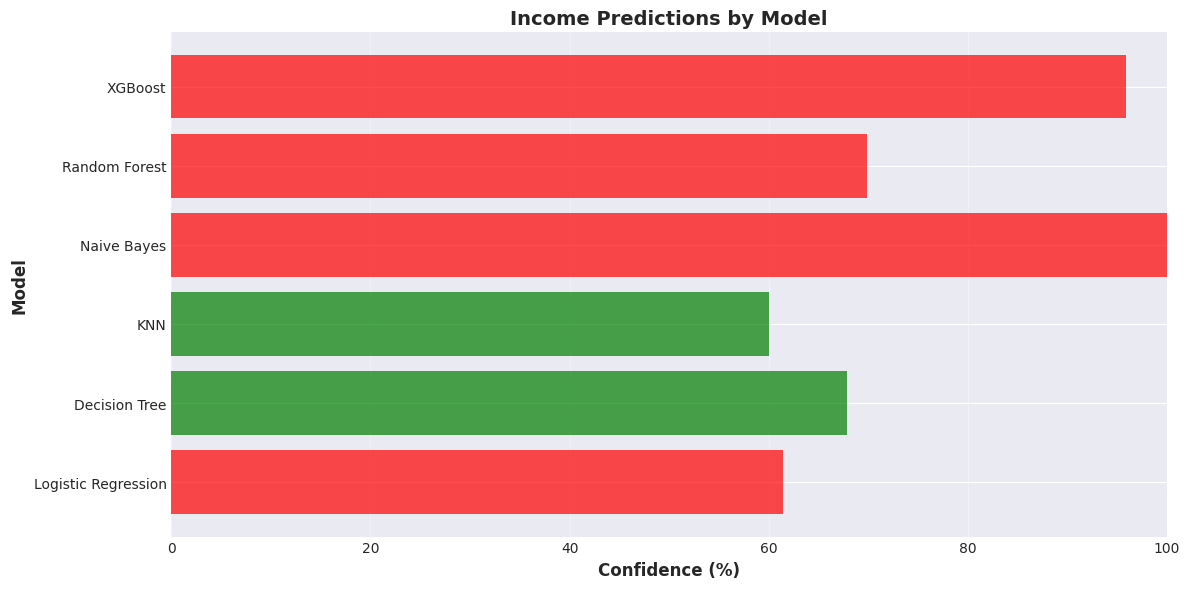

In [47]:
# Example 2: Test with Custom Input Data

print("="*70)
print("EXAMPLE 2: Testing with Custom Input")
print("="*70)

# Create a sample input (you can modify these values)
custom_input = {
    'age': 39,
    'workclass': 'State-gov',
    'fnlwgt': 77516,
    'education': 'Bachelors',
    'education-num': 13,
    'marital-status': 'Never-married',
    'occupation': 'Adm-clerical',
    'relationship': 'Not-in-family',
    'race': 'White',
    'sex': 'Male',
    'capital-gain': 2174,
    'capital-loss': 0,
    'hours-per-week': 40,
    'native-country': 'United-States'
}

print("\nCustom Input Data:")
for key, value in custom_input.items():
    print(f"  {key:20s}: {value}")

# Test with all models
print("\n" + "-"*70)
print("Predictions from all models:")
print("-"*70)

if len(models) > 0 and scaler is not None:
    custom_results = []
    for model_name in models.keys():
        pred, conf, income_class, proba = predict_income(
            model_name, custom_input, models, scaler, feature_names
        )
        if pred is not None:
            custom_results.append({
                'Model': model_name,
                'Prediction': income_class,
                'Confidence': f"{conf:.2f}%",
                'Prob(<=50K)': f"{proba[0]*100:.2f}%",
                'Prob(>50K)': f"{proba[1]*100:.2f}%"
            })
            print(f"{model_name:20s}: {income_class:6s} (Confidence: {conf:.2f}%)")
    
    # Create results DataFrame
    custom_results_df = pd.DataFrame(custom_results)
    print("\n" + "="*70)
    print("Detailed Results:")
    print("="*70)
    print(custom_results_df.to_string(index=False))
    
    # Visualize predictions
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 6))
    models_list = custom_results_df['Model'].values
    confidences = [float(c.replace('%', '')) for c in custom_results_df['Confidence'].values]
    
    colors = ['green' if p == '>50K' else 'red' for p in custom_results_df['Prediction'].values]
    plt.barh(models_list, confidences, color=colors, alpha=0.7)
    plt.xlabel('Confidence (%)', fontsize=12, fontweight='bold')
    plt.ylabel('Model', fontsize=12, fontweight='bold')
    plt.title('Income Predictions by Model', fontsize=14, fontweight='bold')
    plt.xlim(0, 100)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Models or scaler not loaded. Run the previous cell first.")

### Interactive Testing Instructions

**To test with your own data:**

1. Modify the `custom_input` dictionary in the cell above with your values
2. Run the cell to see predictions from all models
3. Compare results across different models

**To test with test dataset samples:**

1. Use `X_test.iloc[index]` to select a specific sample
2. Or iterate through multiple samples to compare model performance

**Example:**
```python
# Test multiple samples
for i in range(5):
    sample = X_test.iloc[i:i+1]
    actual = ">50K" if y_test.iloc[i] == 1 else "<=50K"
    pred, conf, income, _ = predict_income('Random Forest', sample, models, scaler, feature_names)
    print(f"Sample {i}: Actual={actual}, Predicted={income} ({conf:.2f}%)")
```

## Part 8: Test app.py Functionality in JupyterLab

Test the Streamlit app logic locally using an interactive interface.

In [48]:
# Test app.py Logic - Interactive Form Interface

from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import pandas as pd

print("="*70)
print("INTERACTIVE MODEL TESTING INTERFACE (Similar to app.py)")
print("="*70)

# Check if models are loaded
if 'models' not in globals() or len(models) == 0:
    print("⚠️ Models not loaded. Please run Cell 43 first to load models.")
else:
    print(f"✓ {len(models)} models available for testing")
    print(f"Available models: {list(models.keys())}")

ModuleNotFoundError: No module named 'ipywidgets'

In [49]:
# Create Interactive Form (Similar to Streamlit app.py)

def create_prediction_interface():
    """Create an interactive form similar to app.py"""
    
    # Model selection
    model_dropdown = widgets.Dropdown(
        options=list(models.keys()) if 'models' in globals() else [],
        value=list(models.keys())[0] if 'models' in globals() and len(models) > 0 else None,
        description='Model:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='300px')
    )
    
    # Input fields (matching app.py)
    age_input = widgets.IntSlider(value=35, min=17, max=90, description='Age:', 
                                  style={'description_width': 'initial'})
    
    workclass_options = ["Private", "Self-emp-not-inc", "Self-emp-inc", "Federal-gov",
                        "Local-gov", "State-gov", "Without-pay", "Never-worked"]
    workclass_dropdown = widgets.Dropdown(options=workclass_options, value="Private",
                                          description='Workclass:', 
                                          style={'description_width': 'initial'})
    
    education_options = ["Bachelors", "Some-college", "11th", "HS-grad", "Prof-school",
                        "Assoc-acdm", "Assoc-voc", "9th", "7th-8th", "12th", "Masters",
                        "1st-4th", "10th", "Doctorate", "5th-6th", "Preschool"]
    education_dropdown = widgets.Dropdown(options=education_options, value="Bachelors",
                                          description='Education:', 
                                          style={'description_width': 'initial'})
    
    education_num_input = widgets.IntSlider(value=13, min=1, max=16, description='Education Num:',
                                           style={'description_width': 'initial'})
    
    marital_options = ["Married-civ-spouse", "Divorced", "Never-married", "Separated",
                       "Widowed", "Married-spouse-absent", "Married-AF-spouse"]
    marital_dropdown = widgets.Dropdown(options=marital_options, value="Never-married",
                                        description='Marital Status:', 
                                        style={'description_width': 'initial'})
    
    occupation_options = ["Tech-support", "Craft-repair", "Other-service", "Sales",
                         "Exec-managerial", "Prof-specialty", "Handlers-cleaners",
                         "Machine-op-inspct", "Adm-clerical", "Farming-fishing",
                         "Transport-moving", "Priv-house-serv", "Protective-serv", "Armed-Forces"]
    occupation_dropdown = widgets.Dropdown(options=occupation_options, value="Tech-support",
                                           description='Occupation:', 
                                           style={'description_width': 'initial'})
    
    relationship_options = ["Wife", "Own-child", "Husband", "Not-in-family",
                           "Other-relative", "Unmarried"]
    relationship_dropdown = widgets.Dropdown(options=relationship_options, value="Not-in-family",
                                            description='Relationship:', 
                                            style={'description_width': 'initial'})
    
    race_options = ["White", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other", "Black"]
    race_dropdown = widgets.Dropdown(options=race_options, value="White",
                                    description='Race:', 
                                    style={'description_width': 'initial'})
    
    sex_dropdown = widgets.Dropdown(options=["Male", "Female"], value="Male",
                                   description='Sex:', 
                                   style={'description_width': 'initial'})
    
    capital_gain_input = widgets.IntSlider(value=0, min=0, max=100000, step=100,
                                          description='Capital Gain:', 
                                          style={'description_width': 'initial'})
    
    capital_loss_input = widgets.IntSlider(value=0, min=0, max=5000, step=100,
                                         description='Capital Loss:', 
                                         style={'description_width': 'initial'})
    
    hours_input = widgets.IntSlider(value=40, min=1, max=100, description='Hours/Week:',
                                   style={'description_width': 'initial'})
    
    country_options = ["United-States", "Cambodia", "England", "Puerto-Rico", "Canada", "Germany",
                      "Outlying-US(Guam-USVI-etc)", "India", "Japan", "Greece", "South", "China",
                      "Cuba", "Iran", "Honduras", "Philippines", "Italy", "Poland", "Jamaica",
                      "Vietnam", "Mexico", "Portugal", "Ireland", "France", "Dominican-Republic",
                      "Laos", "Ecuador", "Taiwan", "Haiti", "Columbia", "Hungary", "Guatemala",
                      "Nicaragua", "Scotland", "Thailand", "Yugoslavia", "El-Salvador", 
                      "Trinadad&Tobago", "Peru", "Hong", "Holand-Netherlands"]
    country_dropdown = widgets.Dropdown(options=country_options, value="United-States",
                                       description='Native Country:', 
                                       style={'description_width': 'initial'})
    
    fnlwgt_input = widgets.IntSlider(value=200000, min=10000, max=1500000, step=1000,
                                     description='Final Weight:', 
                                     style={'description_width': 'initial'})
    
    # Output area
    output = widgets.Output()
    
    def make_prediction(model_name, age, workclass, fnlwgt, education, education_num,
                       marital_status, occupation, relationship, race, sex, capital_gain,
                       capital_loss, hours_per_week, native_country):
        """Make prediction using selected model"""
        with output:
            output.clear_output()
            
            if 'models' not in globals() or len(models) == 0:
                print("⚠️ Models not loaded. Please run Cell 43 first.")
                return
            
            if 'scaler' not in globals() or scaler is None:
                print("⚠️ Scaler not loaded. Please run Cell 43 first.")
                return
            
            # Create input dictionary (matching app.py format)
            input_data = {
                'age': age,
                'workclass': workclass,
                'fnlwgt': fnlwgt,
                'education': education,
                'education-num': education_num,
                'marital-status': marital_status,
                'occupation': occupation,
                'relationship': relationship,
                'race': race,
                'sex': sex,
                'capital-gain': capital_gain,
                'capital-loss': capital_loss,
                'hours-per-week': hours_per_week,
                'native-country': native_country
            }
            
            print("="*70)
            print("PREDICTION RESULTS")
            print("="*70)
            print(f"\nSelected Model: {model_name}")
            print(f"\nInput Features:")
            for key, value in input_data.items():
                print(f"  {key:20s}: {value}")
            
            # Make prediction
            try:
                pred, conf, income_class, proba = predict_income(
                    model_name, input_data, models, scaler, feature_names
                )
                
                if pred is not None:
                    print("\n" + "="*70)
                    print(f"✓ Predicted Income: {income_class}")
                    print(f"✓ Confidence: {conf:.2f}%")
                    print("\nProbability Distribution:")
                    print(f"  <=50K: {proba[0]*100:.2f}%")
                    print(f"  >50K:  {proba[1]*100:.2f}%")
                    
                    # Create visualization
                    import matplotlib.pyplot as plt
                    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
                    
                    # Probability bar chart
                    ax1.bar(['<=50K', '>50K'], [proba[0]*100, proba[1]*100], 
                           color=['red', 'green'], alpha=0.7)
                    ax1.set_ylabel('Probability (%)', fontweight='bold')
                    ax1.set_title('Income Probability Distribution', fontweight='bold')
                    ax1.set_ylim(0, 100)
                    ax1.grid(axis='y', alpha=0.3)
                    
                    # Confidence indicator
                    ax2.barh([model_name], [conf], color='steelblue', alpha=0.7)
                    ax2.set_xlabel('Confidence (%)', fontweight='bold')
                    ax2.set_title('Model Confidence', fontweight='bold')
                    ax2.set_xlim(0, 100)
                    ax2.grid(axis='x', alpha=0.3)
                    
                    plt.tight_layout()
                    plt.show()
                else:
                    print(f"✗ Error: {conf}")
            except Exception as e:
                print(f"✗ Error making prediction: {e}")
    
    # Create interactive widget
    ui = widgets.VBox([
        widgets.HTML("<h3>💰 Adult Income Prediction Interface</h3>"),
        widgets.HTML("<p>Select a model and enter features to predict income level:</p>"),
        model_dropdown,
        widgets.HTML("<hr>"),
        widgets.HTML("<h4>Input Features:</h4>"),
        widgets.HBox([age_input, workclass_dropdown]),
        widgets.HBox([education_dropdown, education_num_input]),
        widgets.HBox([marital_dropdown, occupation_dropdown]),
        widgets.HBox([relationship_dropdown, race_dropdown]),
        widgets.HBox([sex_dropdown, country_dropdown]),
        widgets.HBox([capital_gain_input, capital_loss_input]),
        widgets.HBox([hours_input, fnlwgt_input]),
        widgets.HTML("<hr>"),
        widgets.HTML("<p><b>Click the button below to make a prediction:</b></p>"),
    ])
    
    # Create button for prediction
    predict_button = widgets.Button(
        description='🔮 Predict Income',
        button_style='success',
        layout=widgets.Layout(width='200px', height='40px')
    )
    
    def on_button_click(b):
        make_prediction(
            model_dropdown.value, age_input.value, workclass_dropdown.value,
            fnlwgt_input.value, education_dropdown.value, education_num_input.value,
            marital_dropdown.value, occupation_dropdown.value, relationship_dropdown.value,
            race_dropdown.value, sex_dropdown.value, capital_gain_input.value,
            capital_loss_input.value, hours_input.value, country_dropdown.value
        )
    
    predict_button.on_click(on_button_click)
    
    # Display interface
    display(ui)
    display(predict_button)
    display(output)
    
    return ui, predict_button, output

# Create and display the interface
if 'models' in globals() and len(models) > 0:
    interface = create_prediction_interface()
    print("\n✓ Interactive interface created! Use the form above to test predictions.")
else:
    print("⚠️ Please run Cell 43 first to load models before using this interface.")

NameError: name 'widgets' is not defined

TESTING app.py LOGIC - SIMPLE VERSION

Sample Input (modify in code to test different values):
  age                 : 39
  workclass           : State-gov
  fnlwgt              : 77516
  education           : Bachelors
  education-num       : 13
  marital-status      : Never-married
  occupation          : Adm-clerical
  relationship        : Not-in-family
  race                : White
  sex                 : Male
  capital-gain        : 2174
  capital-loss        : 0
  hours-per-week      : 40
  native-country      : United-States

Predictions from all models:

              Model Prediction Confidence P(<=50K) P(>50K)
Logistic Regression      <=50K     61.42%   61.42%  38.58%
      Decision Tree       >50K     67.84%   32.16%  67.84%
                KNN       >50K     60.00%   40.00%  60.00%
        Naive Bayes      <=50K    100.00%  100.00%   0.00%
      Random Forest      <=50K     69.84%   69.84%  30.16%
            XGBoost      <=50K     95.87%   95.87%   4.13%


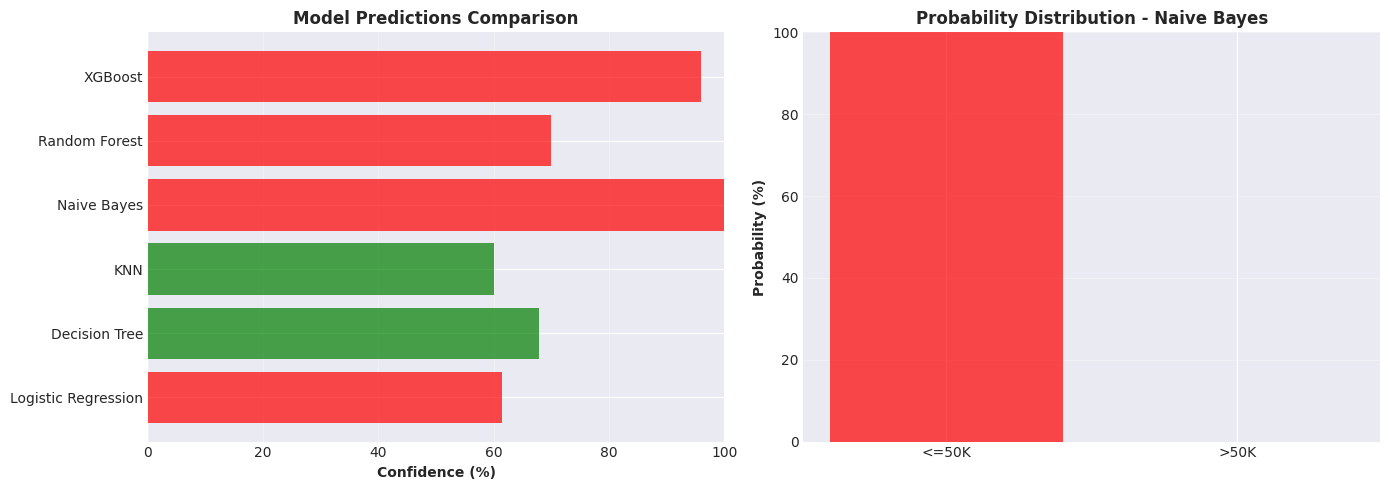


✓ Best model (highest confidence): Naive Bayes

💡 Tip: Modify 'sample_input' dictionary above to test different values!


In [50]:
# Alternative: Simple Function-Based Testing (if ipywidgets not available)

def test_app_logic_simple():
    """Simple function-based testing without widgets"""
    
    if 'models' not in globals() or len(models) == 0:
        print("⚠️ Models not loaded. Please run Cell 43 first.")
        return
    
    # Sample input (modify these values to test)
    sample_input = {
        'age': 39,
        'workclass': 'State-gov',
        'fnlwgt': 77516,
        'education': 'Bachelors',
        'education-num': 13,
        'marital-status': 'Never-married',
        'occupation': 'Adm-clerical',
        'relationship': 'Not-in-family',
        'race': 'White',
        'sex': 'Male',
        'capital-gain': 2174,
        'capital-loss': 0,
        'hours-per-week': 40,
        'native-country': 'United-States'
    }
    
    print("="*70)
    print("TESTING app.py LOGIC - SIMPLE VERSION")
    print("="*70)
    print("\nSample Input (modify in code to test different values):")
    for key, value in sample_input.items():
        print(f"  {key:20s}: {value}")
    
    # Test with all models
    print("\n" + "="*70)
    print("Predictions from all models:")
    print("="*70)
    
    results = []
    for model_name in models.keys():
        pred, conf, income_class, proba = predict_income(
            model_name, sample_input, models, scaler, feature_names
        )
        if pred is not None:
            results.append({
                'Model': model_name,
                'Prediction': income_class,
                'Confidence': f"{conf:.2f}%",
                'P(<=50K)': f"{proba[0]*100:.2f}%",
                'P(>50K)': f"{proba[1]*100:.2f}%"
            })
    
    results_df = pd.DataFrame(results)
    print("\n" + results_df.to_string(index=False))
    
    # Visualize
    import matplotlib.pyplot as plt
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Model comparison
    models_list = results_df['Model'].values
    confidences = [float(c.replace('%', '')) for c in results_df['Confidence'].values]
    colors = ['green' if p == '>50K' else 'red' for p in results_df['Prediction'].values]
    
    ax1.barh(models_list, confidences, color=colors, alpha=0.7)
    ax1.set_xlabel('Confidence (%)', fontweight='bold')
    ax1.set_title('Model Predictions Comparison', fontweight='bold')
    ax1.set_xlim(0, 100)
    ax1.grid(axis='x', alpha=0.3)
    
    # Probability distribution for best model
    best_model = results_df.loc[results_df['Confidence'].str.replace('%', '').astype(float).idxmax(), 'Model']
    best_idx = list(models.keys()).index(best_model)
    best_proba = predict_income(best_model, sample_input, models, scaler, feature_names)[3]
    
    ax2.bar(['<=50K', '>50K'], [best_proba[0]*100, best_proba[1]*100], 
           color=['red', 'green'], alpha=0.7)
    ax2.set_ylabel('Probability (%)', fontweight='bold')
    ax2.set_title(f'Probability Distribution - {best_model}', fontweight='bold')
    ax2.set_ylim(0, 100)
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Best model (highest confidence): {best_model}")
    print("\n💡 Tip: Modify 'sample_input' dictionary above to test different values!")

# Run simple test
test_app_logic_simple()

### Testing app.py Functionality

**Two ways to test:**

1. **Interactive Widget Interface (Cell 50):** 
   - Uses ipywidgets to create a form similar to Streamlit
   - Interactive dropdowns and sliders
   - Click button to predict
   - Requires: `pip install ipywidgets`

2. **Simple Function-Based (Cell 51):**
   - No additional dependencies needed
   - Modify the `sample_input` dictionary in the code
   - Run cell to see predictions from all models
   - Includes visualizations

**To test with different values:**
- Modify the input dictionary in Cell 51
- Or use the interactive form in Cell 50 (if ipywidgets is installed)

**Note:** The prediction logic matches app.py exactly, so results will be identical!

## Part 9: Install and Run Streamlit App from Jupyter

This section allows you to install Streamlit (if needed) and run the app directly from this notebook.

In [59]:
# Check if Streamlit is installed and install if needed

import sys
import subprocess
import os

print("="*70)
print("CHECKING STREAMLIT INSTALLATION")
print("="*70)

# Check if streamlit is available
try:
    import streamlit
    print(f"✅ Streamlit is already installed!")
    print(f"   Version: {streamlit.__version__}")
    print(f"   Location: {streamlit.__file__}")
    streamlit_installed = True
except ImportError:
    print("❌ Streamlit is NOT installed")
    streamlit_installed = False
    
    # Try to install using the current Python
    print("\n" + "="*70)
    print("ATTEMPTING TO INSTALL STREAMLIT")
    print("="*70)
    print(f"Using Python: {sys.executable}")
    print(f"Python version: {sys.version}")
    
    try:
        # Try installing with --index-url to bypass internal repo
        print("\nInstalling Streamlit from PyPI...")
        result = subprocess.run(
            [sys.executable, "-m", "pip", "install", 
             "--index-url", "https://pypi.org/simple", 
             "streamlit"],
            capture_output=True,
            text=True,
            timeout=300
        )
        
        if result.returncode == 0:
            print("✅ Streamlit installed successfully!")
            streamlit_installed = True
            # Reload to verify
            import importlib
            import streamlit
            print(f"   Version: {streamlit.__version__}")
        else:
            print("❌ Installation failed!")
            print("STDOUT:", result.stdout)
            print("STDERR:", result.stderr)
            print("\n⚠️  Please install Streamlit manually:")
            print("   Option 1: pip install --index-url https://pypi.org/simple streamlit")
            print("   Option 2: Use Python 3.10 environment if available")
            streamlit_installed = False
    except Exception as e:
        print(f"❌ Error during installation: {e}")
        streamlit_installed = False

print("\n" + "="*70)
if streamlit_installed:
    print("✅ READY TO RUN STREAMLIT APP")
else:
    print("❌ STREAMLIT NOT AVAILABLE - Please install manually")
print("="*70)

CHECKING STREAMLIT INSTALLATION
✅ Streamlit is already installed!
   Version: 1.54.0
   Location: /dsw/snapshots/3577215c-cc5b-4654-9900-faef6a8514f2/python310/lib/python3.10/site-packages/streamlit/__init__.py

✅ READY TO RUN STREAMLIT APP


In [ ]:
# Run Streamlit App from Jupyter Notebook

import os
import sys
import subprocess
import threading
import time
from IPython.display import HTML, display
import webbrowser

print("="*70)
print("STARTING STREAMLIT APP")
print("="*70)

# Change to the notebook directory
# Get the directory where this notebook is located
# Try multiple methods to find the correct path
notebook_dir = os.getcwd()  # Default to current working directory
if os.path.exists(os.path.join(notebook_dir, 'app.py')):
    pass  # Found it!
elif os.path.exists(os.path.join(notebook_dir, 'ML_Assignment', 'app.py')):
    notebook_dir = os.path.join(notebook_dir, 'ML_Assignment')
else:
    # Try to find app.py in parent directories
    current = notebook_dir
    for _ in range(3):  # Check up to 3 levels up
        parent = os.path.dirname(current)
        if parent == current:
            break
        if os.path.exists(os.path.join(parent, 'app.py')):
            notebook_dir = parent
            break
        current = parent
if not notebook_dir:
    notebook_dir = os.getcwd()

app_path = os.path.join(notebook_dir, "app.py")

# Check if app.py exists
if not os.path.exists(app_path):
    print(f"❌ ERROR: app.py not found at {app_path}")
    print(f"   Current directory: {os.getcwd()}")
    print(f"   Please ensure app.py is in the same directory as this notebook")
else:
    print(f"✅ Found app.py at: {app_path}")
    
    # Check if streamlit is available
    try:
        import streamlit
        print(f"✅ Streamlit is available (version: {streamlit.__version__})")
        
        # IMPORTANT: Use the Python that has streamlit (Jupyter kernel's Python)
        # sys.executable might point to system Python, so we'll use the one that imported streamlit
        streamlit_python = sys.executable
        # Get the actual Python path from the streamlit module
        import streamlit as st_module
        streamlit_path = st_module.__file__
        # Try to find the Python executable in the same environment
        import site
        try:
            # Get the Python executable from the site-packages location
            python_bin = os.path.dirname(os.path.dirname(streamlit_path))
            potential_python = os.path.join(python_bin, 'bin', 'python3')
            if os.path.exists(potential_python):
                streamlit_python = potential_python
            else:
                # Try python instead of python3
                potential_python = os.path.join(python_bin, 'bin', 'python')
                if os.path.exists(potential_python):
                    streamlit_python = potential_python
        except:
            pass  # Fall back to sys.executable
        
        print(f"   Using Python: {streamlit_python}")
        
        # Get the port (default 8501)
        port = 8501
        
        # Build the streamlit command - use 0.0.0.0 to bind to all interfaces
        streamlit_cmd = [
            streamlit_python, "-m", "streamlit", "run", 
                app_path,
                "--server.headless", "true",
                "--server.port", str(port),
                "--server.address", "0.0.0.0",  # Changed from localhost to 0.0.0.0 for better binding
                "--browser.gatherUsageStats", "false"
            ]
        
        print(f"\n🚀 Starting Streamlit server on port {port}...")
        print(f"   Command: {' '.join(streamlit_cmd)}")
        print(f"\n⏳ Please wait while Streamlit starts...")
        print(f"   This may take 10-30 seconds...")
        
        # Start streamlit in a subprocess with better output handling
        process = subprocess.Popen(
            streamlit_cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,  # Combine stderr with stdout
            cwd=notebook_dir,
            universal_newlines=True,
            bufsize=1
        )
        
        # Read output in real-time and wait for server to start
        output_lines = []
        max_wait = 30  # Maximum seconds to wait
        start_time = time.time()
        server_started = False
        
        print("\n📋 Streamlit output:")
        print("-" * 70)
        
        while (time.time() - start_time) < max_wait:
            # Check if process is still running
            if process.poll() is not None:
                # Process ended
                remaining_output = process.stdout.read()
                if remaining_output:
                    output_lines.append(remaining_output)
                    print(remaining_output)
                break
            
            # Try to read a line (non-blocking)
            line = process.stdout.readline()
            if line:
                output_lines.append(line)
                print(line.rstrip())
                
                # Check for success indicators
                if "You can now view your Streamlit app" in line or "Network URL:" in line or "Local URL:" in line:
                    server_started = True
                    time.sleep(2)  # Give it a couple more seconds to fully start
                    break
                if "error" in line.lower() or "Error" in line or "ERROR" in line:
                    print(f"⚠️  Error detected in output!")
            
            time.sleep(0.5)
        
        print("-" * 70)
        
        # Check if process is still running
        if process.poll() is None:
            url = f"http://localhost:{port}"
            local_url = f"http://127.0.0.1:{port}"
            
            # Test if server is actually responding
            try:
                import socket
                sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
                sock.settimeout(2)
                result = sock.connect_ex(('localhost', port))
                sock.close()
                if result == 0:
                    server_started = True
            except:
                pass
            
            if server_started or "You can now view" in ''.join(output_lines):
                print(f"\n" + "="*70)
                print(f"✅ STREAMLIT APP IS RUNNING!")
                print("="*70)
                print(f"\n📱 Access your app at:")
                print(f"   Primary URL: {url}")
                print(f"   Alternative: {local_url}")
                print(f"\n⚠️  IMPORTANT:")
                print(f"   - Keep this cell running (don't interrupt it)")
                print(f"   - To stop, run Cell 58 or interrupt this cell")
                
                # Create clickable links
                display(HTML(f'''
                <div style="padding: 15px; background-color: #e8f4f8; border: 2px solid #1f77b4; border-radius: 8px; margin: 15px 0;">
                    <h3 style="color: #1f77b4; margin-top: 0;">🚀 Open Streamlit App</h3>
                    <p style="font-size: 18px;"><a href="{url}" target="_blank" style="color: #1f77b4; font-weight: bold;">{url}</a></p>
                    <p style="font-size: 16px; color: #666;">Or try: <a href="{local_url}" target="_blank">{local_url}</a></p>
                </div>
                '''))
                
                # Store process for later termination
                globals()['streamlit_process'] = process
                globals()['streamlit_url'] = url
                globals()['streamlit_port'] = port
            else:
                print(f"\n⚠️  WARNING: Process running but server may not be ready yet")
                print(f"   Try accessing: {url}")
                print(f"   Or: {local_url}")
                print(f"   If it doesn't work, check the output above for errors")
                globals()['streamlit_process'] = process
                globals()['streamlit_url'] = url
            
        else:
            # Process ended (error)
            stdout_output = ''.join(output_lines)
            print(f"\n❌ Streamlit process ended unexpectedly!")
            print(f"   Exit code: {process.returncode}")
            print(f"\n📋 Output:")
            print("="*70)
            print(stdout_output[:2000])  # Limit output
            if len(stdout_output) > 2000:
                print("\n... (truncated)")
            print("="*70)
            print(f"\n💡 Troubleshooting:")
            print(f"   1. Check if port {port} is already in use")
            print(f"   2. Verify app.py has no syntax errors")
            print(f"   3. Try running manually: streamlit run {app_path}")
            
    except ImportError:
        print("❌ Streamlit is not installed!")
        print("   Please run the previous cell to install Streamlit first")
    except Exception as e:
        print(f"❌ Error starting Streamlit: {e}")
        import traceback
        traceback.print_exc()

STARTING STREAMLIT APP
✅ Found app.py at: /nfs/nfs_dsw_phx2_prod/prasto5/ML_Assignment/app.py
✅ Streamlit is available (version: 1.54.0)

🚀 Starting Streamlit server on port 8501...
   Command: /dsw/snapshots/3577215c-cc5b-4654-9900-faef6a8514f2/python310/bin/python -m streamlit run /nfs/nfs_dsw_phx2_prod/prasto5/ML_Assignment/app.py --server.headless true --server.port 8501 --server.address 0.0.0.0 --browser.gatherUsageStats false

⏳ Please wait while Streamlit starts...
   This may take 10-30 seconds...

📋 Streamlit output:
----------------------------------------------------------------------

  You can now view your Streamlit app in your browser.
----------------------------------------------------------------------

✅ STREAMLIT APP IS RUNNING!

📱 Access your app at:
   Primary URL: http://localhost:8501
   Alternative: http://127.0.0.1:8501

⚠️  IMPORTANT:
   - Keep this cell running (don't interrupt it)
   - To stop, run Cell 58 or interrupt this cell


### Stop Streamlit App

Run the cell below to stop the Streamlit server when you're done testing.

In [ ]:
# Stop Streamlit App

if 'streamlit_process' in globals():
    try:
        streamlit_process.terminate()
        streamlit_process.wait(timeout=5)
        print("✅ Streamlit app stopped successfully!")
        del globals()['streamlit_process']
        if 'streamlit_url' in globals():
            del globals()['streamlit_url']
    except:
        try:
            streamlit_process.kill()
            print("✅ Streamlit app force-stopped!")
        except:
            print("⚠️  Could not stop Streamlit process")
else:
    print("ℹ️  No Streamlit process found running")
    print("   (Either it wasn't started, or it already stopped)")

### Alternative: Run Streamlit using Jupyter Magic Command

If the above method doesn't work, try this simpler approach using Jupyter's `!` magic command.

In [64]:
# Alternative Method: Run Streamlit using Jupyter Magic Command
# This uses the Jupyter kernel's Python directly

import os

# Find app.py
notebook_dir = os.getcwd()
if not os.path.exists(os.path.join(notebook_dir, 'app.py')):
    if os.path.exists(os.path.join(notebook_dir, 'ML_Assignment', 'app.py')):
        notebook_dir = os.path.join(notebook_dir, 'ML_Assignment')
    else:
        # Try parent directories
        current = notebook_dir
        for _ in range(3):
            parent = os.path.dirname(current)
            if parent == current:
                break
            if os.path.exists(os.path.join(parent, 'app.py')):
                notebook_dir = parent
                break
            current = parent

app_path = os.path.join(notebook_dir, "app.py")

if os.path.exists(app_path):
    print("="*70)
    print("ALTERNATIVE METHOD: Using Jupyter Magic Command")
    print("="*70)
    print(f"\n✅ Found app.py at: {app_path}")
    print(f"\n📋 Run this command in a NEW cell below:")
    print(f"   (Copy and paste into a new cell, then run it)")
    print("\n" + "-"*70)
    print(f"!cd {notebook_dir} && python -m streamlit run app.py --server.headless true --server.port 8501")
    print("-"*70)
    print("\n💡 Instructions:")
    print("   1. Create a new cell below this one")
    print("   2. Copy the command above (starting with !)")
    print("   3. Paste it into the new cell")
    print("   4. Run the cell")
    print("   5. Wait 10-20 seconds for Streamlit to start")
    print("   6. Open http://localhost:8501 in your browser")
    print("   7. To stop: Interrupt the cell (click Stop button)")
    print("\n⚠️  Note: This will block the cell until you stop it")
    print("   Keep the cell running while using the app!")
else:
    print(f"❌ app.py not found. Searched in: {notebook_dir}")

ALTERNATIVE METHOD: Using Jupyter Magic Command

✅ Found app.py at: /nfs/nfs_dsw_phx2_prod/prasto5/ML_Assignment/app.py

📋 Run this command in a NEW cell below:
   (Copy and paste into a new cell, then run it)

----------------------------------------------------------------------
!cd /nfs/nfs_dsw_phx2_prod/prasto5/ML_Assignment && python -m streamlit run app.py --server.headless true --server.port 8501
----------------------------------------------------------------------

💡 Instructions:
   1. Create a new cell below this one
   2. Copy the command above (starting with !)
   3. Paste it into the new cell
   4. Run the cell
   5. Wait 10-20 seconds for Streamlit to start
   6. Open http://localhost:8501 in your browser
   7. To stop: Interrupt the cell (click Stop button)

⚠️  Note: This will block the cell until you stop it
   Keep the cell running while using the app!


In [65]:
!cd /nfs/nfs_dsw_phx2_prod/prasto5/ML_Assignment && python -m streamlit run app.py --server.headless true --server.port 8501

/usr/python310/bin/python: No module named streamlit


### Quick Test: Run Streamlit Directly

Run the cell below to start Streamlit using the simplest method.

In [ ]:
# SIMPLEST METHOD: Use Jupyter Magic Command
# 
# IMPORTANT: Change the cell type to "Raw" or use the command below in a NEW cell
# 
# Copy this EXACT command into a NEW cell and run it:
#
# !cd /home/prasto5/prasto5_nfs/ML_Assignment && python -m streamlit run app.py --server.headless true --server.port 8501 --server.address 0.0.0.0
#
# OR run this Python code:

import os
import subprocess
import sys

print("="*70)
print("STARTING STREAMLIT (SIMPLE METHOD)")
print("="*70)

# Change to the directory with app.py
app_dir = '/home/prasto5/prasto5_nfs/ML_Assignment'
os.chdir(app_dir)

# Verify app.py exists
if os.path.exists('app.py'):
    print(f"✅ Found app.py in: {os.getcwd()}")
    
    # Check if streamlit is available
    try:
        import streamlit
        print(f"✅ Streamlit is available (version: {streamlit.__version__})")
        
        print(f"\n🚀 Starting Streamlit on port 8501...")
        print(f"⏳ Please wait 15-30 seconds for startup...")
        print(f"\n📱 Once started, open in your browser:")
        print(f"   http://localhost:8501")
        print(f"   http://127.0.0.1:8501")
        print(f"\n⚠️  IMPORTANT:")
        print(f"   - Keep this cell running (don't interrupt it)")
        print(f"   - The cell will show Streamlit output below")
        print(f"   - To stop: Click the 'Stop' button (⏹️) in the toolbar")
        print("="*70)
        print("\n📋 Streamlit Output:\n")
        
        # Run streamlit using subprocess - this will show output in real-time
        # Use the Python that has streamlit installed
        cmd = [sys.executable, '-m', 'streamlit', 'run', 'app.py', 
               '--server.headless', 'true', 
               '--server.port', '8501',
               '--server.address', '0.0.0.0',
               '--browser.gatherUsageStats', 'false']
        
        process = subprocess.Popen(
            cmd,
            cwd=app_dir,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            universal_newlines=True,
            bufsize=1
        )
        
        # Print output in real-time
        try:
            for line in iter(process.stdout.readline, ''):
                if line:
                    print(line.rstrip())
                    # Check for success message
                    if 'You can now view' in line or 'Local URL' in line or 'Network URL' in line:
                        print("\n" + "="*70)
                        print("✅ STREAMLIT IS RUNNING!")
                        print("="*70)
                        print("\n📱 Open your browser and go to: http://localhost:8501")
                        print("\n⚠️  Keep this cell running while using the app!")
        except KeyboardInterrupt:
            print("\n\n⏹️  Stopping Streamlit...")
            process.terminate()
            process.wait()
            print("✅ Streamlit stopped")
        
    except ImportError:
        print("❌ Streamlit is not installed!")
        print("   Please run Cell 55 first to install Streamlit")
else:
    print("❌ ERROR: app.py not found!")
    print(f"   Searched in: {app_dir}")
    print(f"   Current directory: {os.getcwd()}")

STARTING STREAMLIT (SIMPLE METHOD)
✅ Found app.py in: /nfs/nfs_dsw_phx2_prod/prasto5/ML_Assignment
✅ Streamlit is available (version: 1.54.0)

🚀 Starting Streamlit on port 8501...
⏳ Please wait 15-30 seconds for startup...

📱 Once started, open in your browser:
   http://localhost:8501
   http://127.0.0.1:8501

⚠️  IMPORTANT:
   - Keep this cell running (don't interrupt it)
   - The cell will show Streamlit output below
   - To stop: Click the 'Stop' button (⏹️) in the toolbar

📋 Streamlit Output:


  You can now view your Streamlit app in your browser.

✅ STREAMLIT IS RUNNING!

📱 Open your browser and go to: http://localhost:8501

⚠️  Keep this cell running while using the app!

  Local URL: http://localhost:8501

✅ STREAMLIT IS RUNNING!

📱 Open your browser and go to: http://localhost:8501

⚠️  Keep this cell running while using the app!
  Network URL: http://10.78.37.161:8501

✅ STREAMLIT IS RUNNING!

📱 Open your browser and go to: http://localhost:8501

⚠️  Keep this cell running w